# NOAA Dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from skmultiflow.data import HyperplaneGenerator

import scipy.stats as stats
from scipy.stats import norm

import random
from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import anderson

import tensorflow
import tensorflow.keras.backend as K
import tensorflow.keras.layers as layers

import warnings
warnings.filterwarnings('ignore')


In [2]:
df=pd.read_csv("D:/Concept Drift Papers for Proposal Defence/Datasets/NOAA.csv")

In [3]:
df

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,class
0,19.8,14.0,1019.6,8.4,9.9,15.9,28.9,14.0,1
1,26.8,22.2,1006.2,8.1,10.9,19.0,34.0,21.0,1
2,34.6,32.9,1004.6,3.9,13.8,22.0,36.0,33.1,2
3,26.4,21.5,1006.9,8.0,18.7,30.1,39.9,16.0,2
4,14.7,7.9,1009.9,8.1,14.1,22.0,21.0,9.0,1
...,...,...,...,...,...,...,...,...,...
18154,32.6,21.9,1022.7,7.0,12.4,26.0,41.0,24.8,2
18155,36.8,25.4,1014.9,7.0,10.0,19.0,57.2,21.2,1
18156,41.9,29.9,1010.0,7.0,4.7,9.9,62.6,28.4,1
18157,42.4,29.7,1011.3,7.0,3.3,8.9,51.8,32.0,1


In [4]:
df['class'].value_counts()

1    12461
2     5698
Name: class, dtype: int64

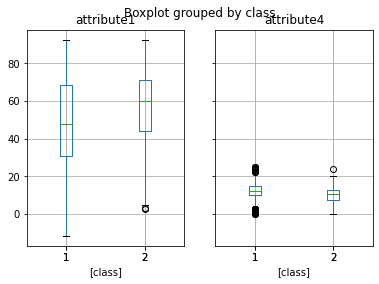

In [5]:
boxplot = df.boxplot(column=['attribute1','attribute4'], by=['class'])

<AxesSubplot:xlabel='class', ylabel='attribute7'>

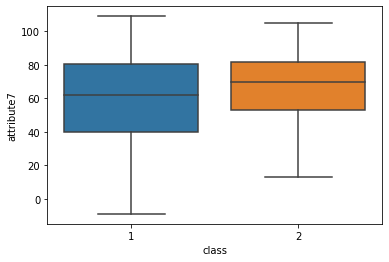

In [6]:
sns.boxplot( x = 'class',y = 'attribute7', data = df )

In [7]:
#data_neg=df[df['class']==1]  # No Rain

In [8]:
#data_pos=df[df['class']==2] # Rain

In [9]:
def encode_all(data,label_col):
        
    # Apply Label Encoding
    encoder=LabelEncoder()
    for col in data.columns:
        if ((data[col].dtype=='object')and (col!=label_col)): 
            data = pd.get_dummies(data, columns=[col])
            
   # Apply Minmax Normalization 
    for col in data.columns:
        if (((data[col].dtype=='float64')or(data[col].dtype=='int64')) and (col!=label_col)): 
            data[col] = np.round((data[col] - data[col].min()) / (data[col].max() - data[col].min()) ,3)  
        
    train=data[0:int(len(data)*0.80)]
    test=data[int((0.80*len(data))):int((0.90*len(data)))]
    stream=data[int((0.90*len(data))):len(data)]
    
    train_positives = train[train[label_col] == 2]
    train_negatives = train[train[label_col] == 1]
    
    X_positive=train_positives.drop([label_col],axis=1)
    X_negative=train_negatives.drop([label_col],axis=1)
    return data , train, test, X_positive,X_negative , stream 

In [10]:
data , train, test, X_positive,X_negative , stream =encode_all(df,'class')

In [11]:
stream['class'].value_counts()

1    1165
2     651
Name: class, dtype: int64

In [12]:
def autoencoder (train,epochs,val_set):
    
    # set bottleneck 1/3 of the input layer size
    encoding_dim = int(np.floor(train.shape[-1]/3))
    
    # input layer size= # of attributes in the dataset after one-hot encoding
    input_layer = tensorflow.keras.Input(shape=train.shape[1:]) # Input Layer
    
    encoded = layers.Dense(encoding_dim, activation='sigmoid')(input_layer) # Code Layer
    decoded = layers.Dense(train.shape[1], activation='sigmoid')(encoded) # Output Laye
       
    
    autoencoder = tensorflow.keras.Model(input_layer, decoded)
    # above model maps an input to its reconstruction 
    
    encoder = tensorflow.keras.Model(input_layer, encoded)
    # above model maps input to its encoded representation 
    
   
    encoded_input = tensorflow.keras.Input(shape=(encoding_dim,))# Encoded Input
    decoder_layer = autoencoder.layers[-1]# Retrieve last layer of autoencoder model defined above
    decoder = tensorflow.keras.Model(encoded_input, decoder_layer(encoded_input))# Decoder Model
          
    autoencoder.compile(optimizer='adam', loss='mse') # Train autoencoder 
    history=autoencoder.fit(train,train, 
                epochs=epochs,
                batch_size=32,
                shuffle=True,
                validation_data=(val_set, val_set)).history
    return  autoencoder , history

In [13]:
def train_encoders(X_Positive,X_Negative, epochs):
    
    X_Positive_train=X_Positive[0:int(len(X_Positive)*0.90)]
    X_Positive_test=X_Positive[int((0.90*len(X_Positive))):len(X_Positive)-1]
    
    X_Negative_train=X_Negative[0:int(len(X_Negative)*0.90)]
    X_Negative_test=X_Negative[int((0.90*len(X_Negative))):len(X_Negative)-1]

    print("Training Autoencoder on Positive Examples ")
    encoder_pos_class, history_positive_class=autoencoder(X_Positive_train,epochs,X_Positive_test)
    print("Training Autoencoder on Negative Examples ")
    encoder_neg_class,history_negative_class=autoencoder(X_Negative_train,epochs,X_Negative_test)
    
    return encoder_pos_class, history_positive_class ,encoder_neg_class,history_negative_class

In [14]:
encoder_pos_class, history_positive_class ,encoder_neg_class,history_negative_class=train_encoders(X_positive,X_negative,100)

Training Autoencoder on Positive Examples 
Epoch 1/100
125/125 [==============================] - 2s 15ms/step - loss: 0.0737 - val_loss: 0.0568
Epoch 2/100
125/125 [==============================] - ETA: 0s - loss: 0.053 - 0s 2ms/step - loss: 0.0529 - val_loss: 0.0421
Epoch 3/100
125/125 [==============================] - 0s 2ms/step - loss: 0.0408 - val_loss: 0.0336
Epoch 4/100
125/125 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.0284
Epoch 5/100
125/125 [==============================] - 0s 2ms/step - loss: 0.0293 - val_loss: 0.0250
Epoch 6/100
125/125 [==============================] - 0s 2ms/step - loss: 0.0263 - val_loss: 0.0225
Epoch 7/100
125/125 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.0208
Epoch 8/100
125/125 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0194
Epoch 9/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0208 - val_loss: 0.0185
Epoch 10/100
125/125 [=

In [17]:
#Plot the model loss(train/test) for give number of epochs
def plot_loss(history):
    plt.plot(history['loss'], linewidth=2, label='Training_Loss')
    plt.plot(history['val_loss'], linewidth=2, label='Validation_Loss')
    plt.legend(loc='upper right')
    plt.title('Model Training loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    #plt.ylim(ymin=0.70,ymax=1)
    plt.savefig('training.png')
    plt.show()

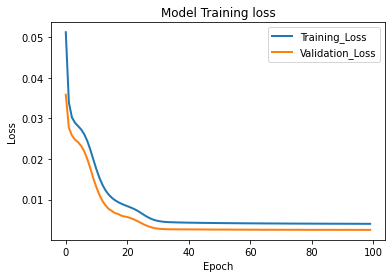

In [18]:
plot_loss(history_negative_class)

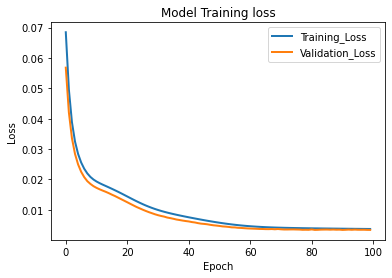

In [19]:
plot_loss(history_positive_class)

In [20]:
def mse_predictions(test, encoder):
    #test=data[int((0.66*len(data))):len(data)-1]
    #pos_test, neg_test=encode(test)
    #Y_test=test['class']
    #X_test=test.drop(['class'],axis=1)
    test=np.array(test)
    predictions=[]
    for i in range(0, test.shape[0]):
        ROW = np.array([test[i]])
        pred= encoder.predict(ROW) 
        mse = np.mean(np.power(test[i] - pred, 2))
        predictions.append(mse)
        #print(test[i] ,pred,mse)
    return predictions

In [150]:
def plot_results(predictions):
    df=pd.DataFrame(predictions,columns=['MSE'])
    #df['class']=pd.Series(Y_test)
    df['MSE']=df['MSE'].round(2)
    #df_positive_class=df[df['class']==1]
    #df_negative_class=df[df['class']==0]
   
    mean=np.round(np.mean( df['MSE']),3)
    max=np.round(np.max( df['MSE']),3)
    min=np.round(np.min( df['MSE']),3)
    var=np.round(np.var( df['MSE']),3)
    med=np.round(np.median(df['MSE']),3)
    
    
    f, axes = plt.subplots(1, 2,figsize=(16,4))
    f.suptitle('Boxplots and Normal Distribution plot for MSE Distribution')
    #axes[0, 0].set_title('MSE of Positive Class')
    sns.boxplot(x=df['MSE'], data=df, ax=axes[0])
    #axes[0, 1].set_title('MSE of Negative Class')    
    #sns.boxplot(x=df_negative_class['MSE'], data=df_negative_class  , ax=axes[1])
    sns.distplot(x=df['MSE'],  ax=axes[1])
    print('mean={},median={} ,max={},min={},variance={}'.format(mean,med,max,min,var))
    
    fig, ax = plt.subplots(figsize=(16,5))
    ax.set_title('MSE plot ')
    plt.plot(df['MSE'],label="MSE")
    #plt.plot(df_positive_class['MSE'],label="MSE of Positive Class")
    plt.legend()
    plt.show()  
    #return df

In [22]:
test_pos_class=test[test['class']==2]
test_neg_class=test[test['class']==1]

In [23]:
del test_pos_class['class']
del test_neg_class['class']

In [24]:
predictions_neg=mse_predictions(test_neg_class,encoder_neg_class)

mean=0.002,median=0.0 ,max=0.04,min=0.0,variance=0.0


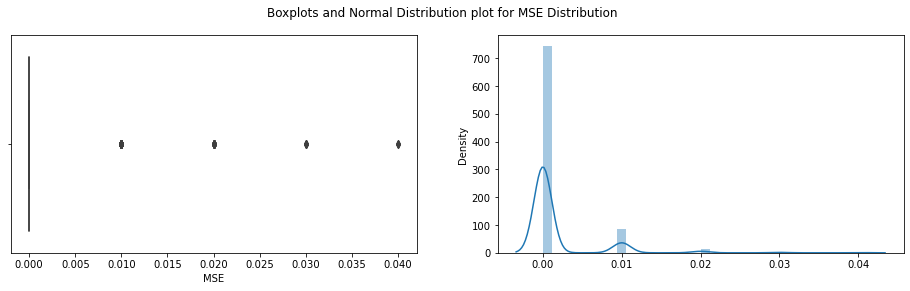

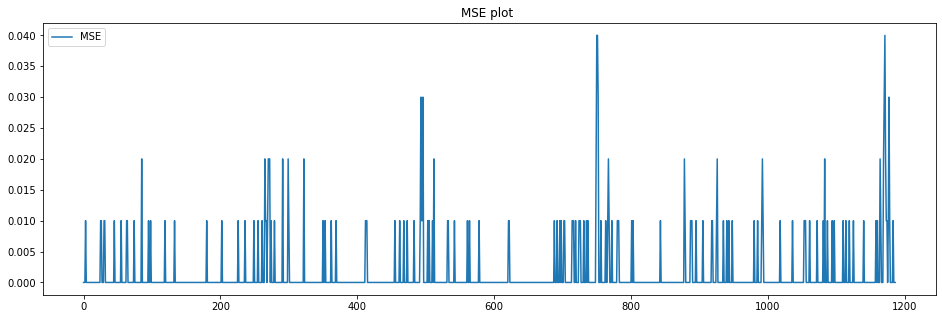

In [151]:
plot_results(predictions_neg)

In [26]:
def make_batches(test_data):
    data=np.array(test_data)
    batch_size=32
    batches={}
    count=0
    for index in range(0,data.shape[0],batch_size):
        batches[count]=data[index:min(index+batch_size,data.shape[0]),:]
        count+=1
    return batches,batch_size
    #print(batch.shape) 

In [27]:
batches_neg,batch_size=make_batches(test_neg_class)

In [28]:
type(batches_neg)

dict

In [29]:
# Anderson-Darling Test
def Anderson_Darling(data):
    result = anderson(data)
    print('Statistic: %.3f' % result.statistic)
    p = 0
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < result.critical_values[i]:
            print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
        else:
            print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

In [30]:
# D'Agostino and Pearson's Test
def D_Agostino(data):
    stat, p = normaltest(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

In [31]:
# Shapiro-Wilk Test
def Shapiro_Wilk(data):
    stat, p = shapiro(data)
    print('Statistics=%.3f, p=%.10f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

In [32]:
def compute_instance_loss_batch_loss(batch,batch_size,encoder):
    mse_list=[]
    mse_sum=0  
    for i in range(0,batch.shape[0]):
        ROW = np.array([batch[i]])
        pred= encoder.predict(ROW) 
        mse = np.round(np.mean(np.power(batch[i] - pred, 2)),5)
        mse_list.append(mse)
        mse_sum+=mse
    avg_mse=mse_sum/batch_size
    return mse_list,avg_mse   
    

In [33]:
def check_all_batch_normality(batches,encoder,batch_size):
    batch_avg_mse=[]
    batch_mse_values={}
    for b in batches:
        print("\n ********************")
        print('Batch: {}'.format(b))
        mse_list,average_mse=compute_instance_loss_batch_loss(batches[b],batch_size,encoder)
        plot_results(mse_list)
        
        print("\nShapiro_Wilk Test")
        #Shapiro_Wilk(mse_list)
       # print("D_Agostino Test")
       # D_Agostino(mse_list)
        print("\nAnderson_Darling Test")
        #Anderson_Darling(mse_list)
        batch_avg_mse.append(average_mse)
        batch_mse_values[b]=mse_list
    return batch_avg_mse,batch_mse_values


 ********************
Batch: 0
mean=0.002,median=0.0 ,max=0.01,min=0.0,variance=0.0


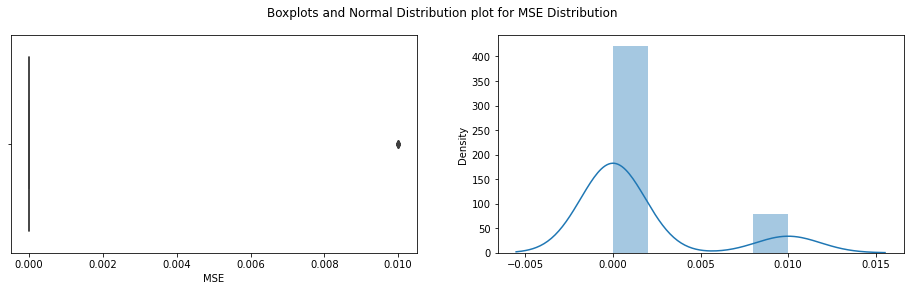

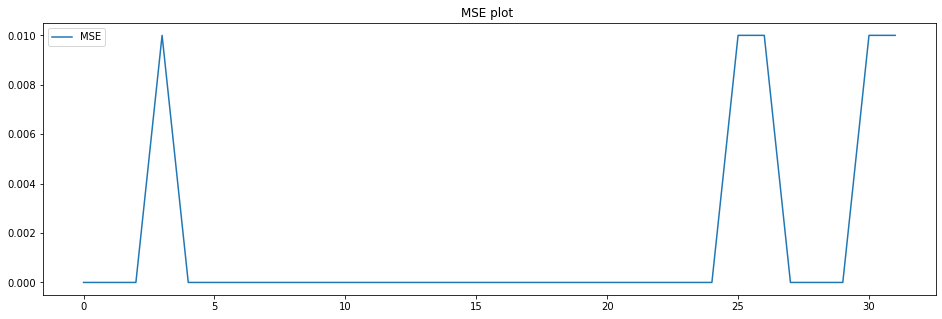


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 1
mean=0.001,median=0.0 ,max=0.01,min=0.0,variance=0.0


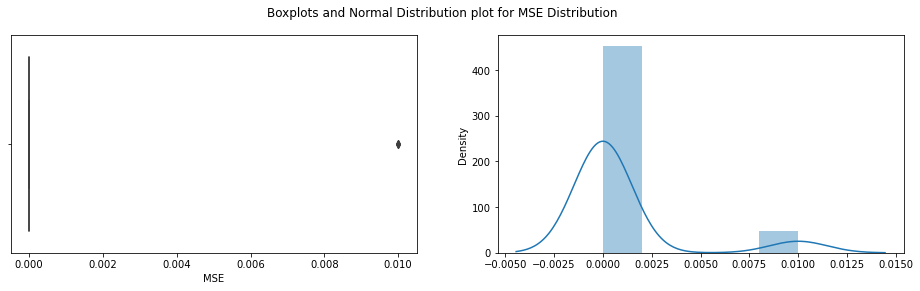

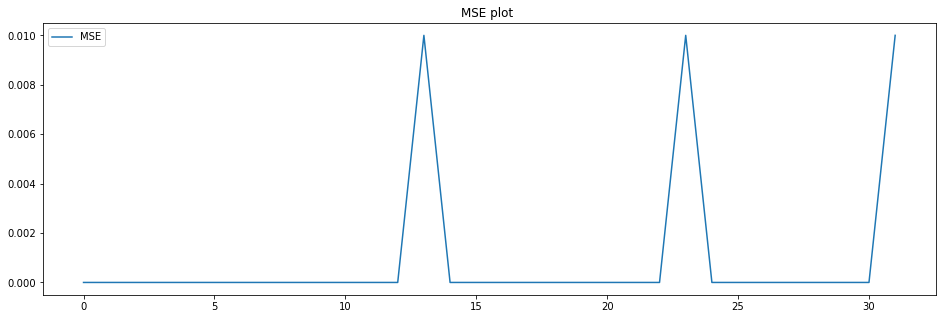


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 2
mean=0.002,median=0.0 ,max=0.02,min=0.0,variance=0.0


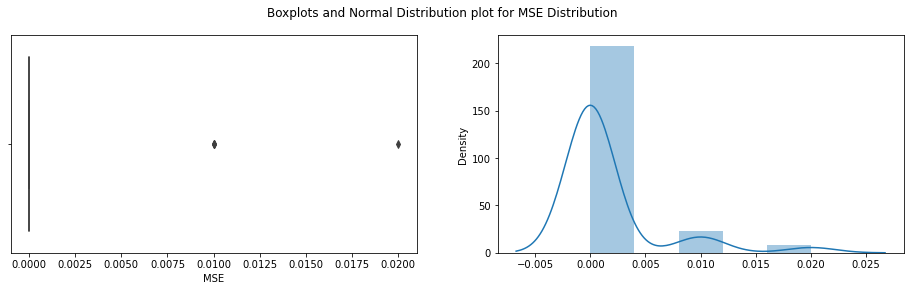

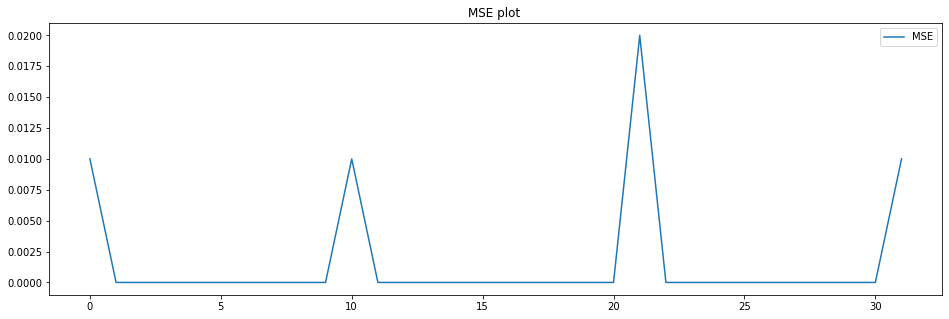


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 3
mean=0.001,median=0.0 ,max=0.01,min=0.0,variance=0.0


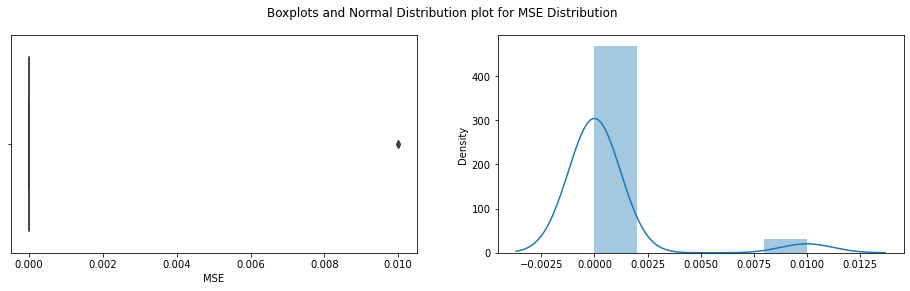

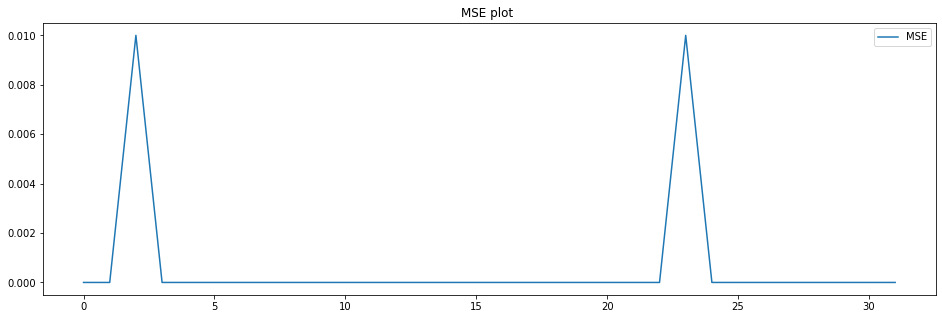


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 4
mean=0.0,median=0.0 ,max=0.01,min=0.0,variance=0.0


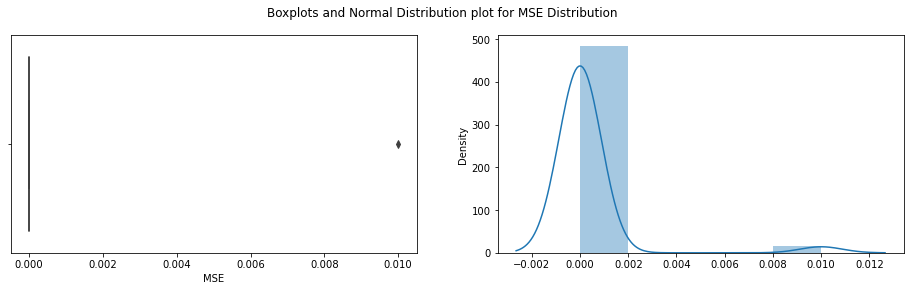

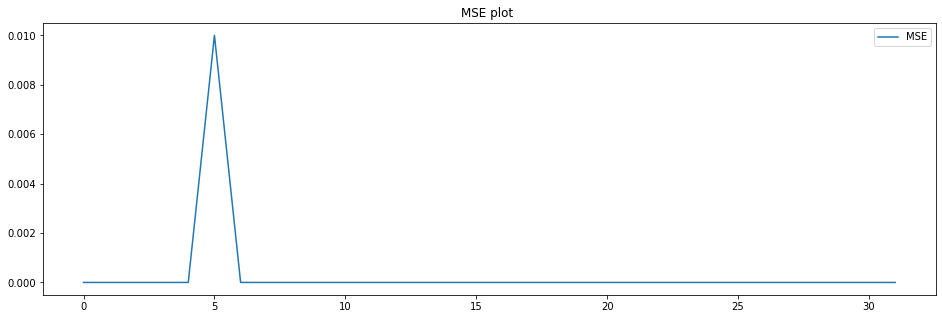


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 5
mean=0.0,median=0.0 ,max=0.01,min=0.0,variance=0.0


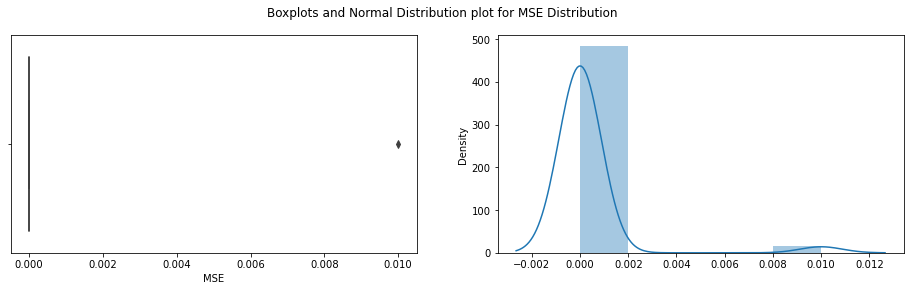

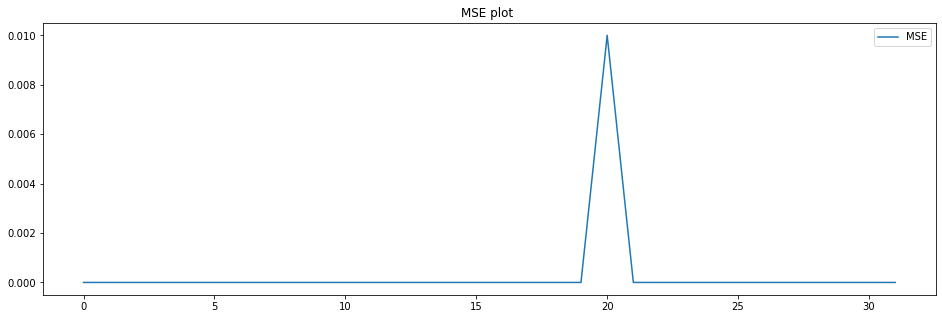


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 6
mean=0.0,median=0.0 ,max=0.01,min=0.0,variance=0.0


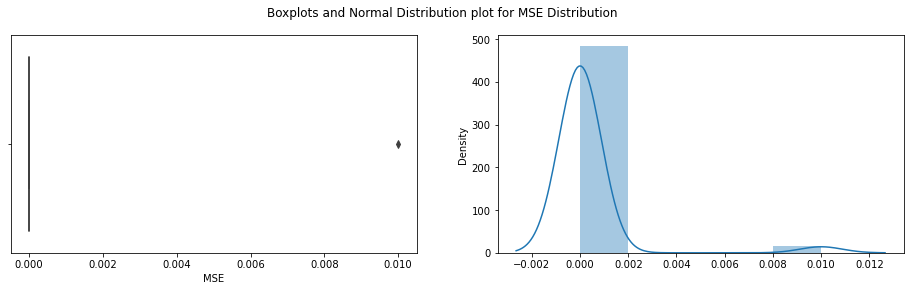

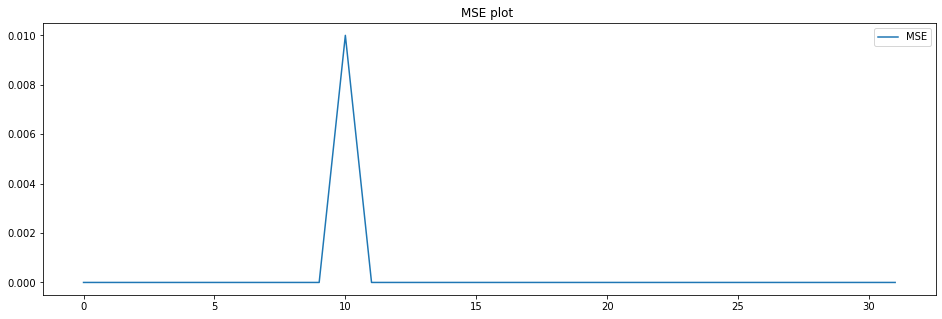


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 7
mean=0.001,median=0.0 ,max=0.01,min=0.0,variance=0.0


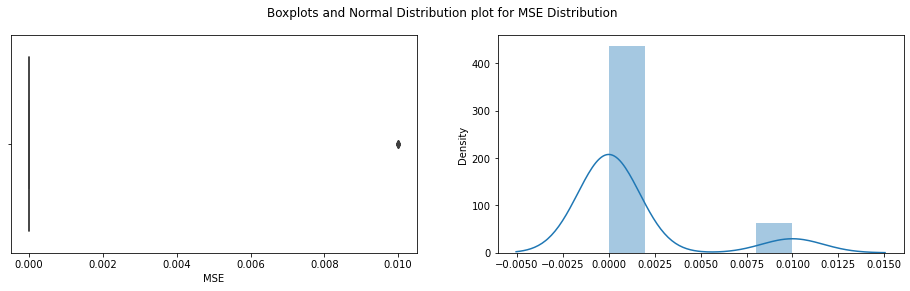

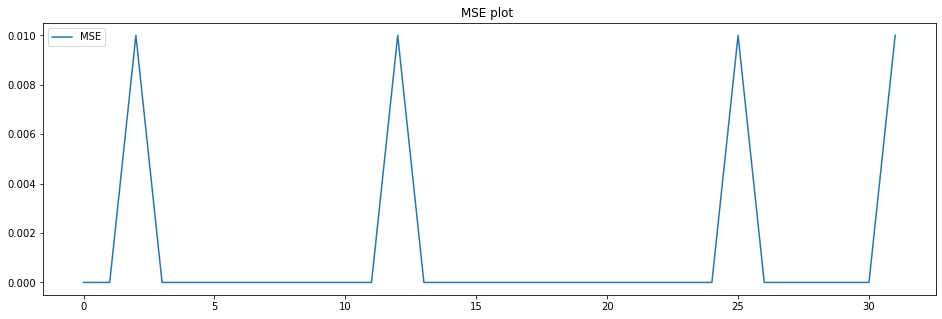


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 8
mean=0.004,median=0.0 ,max=0.02,min=0.0,variance=0.0


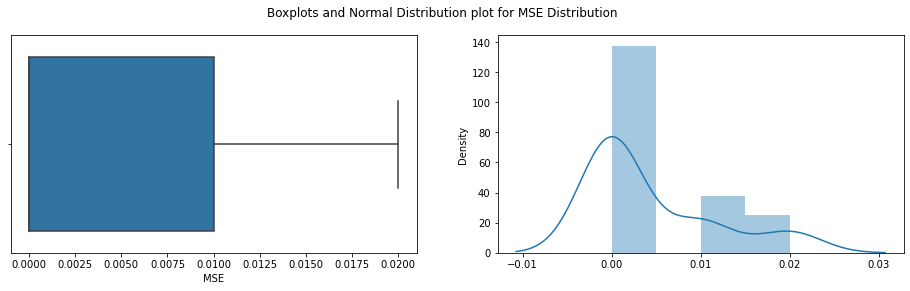

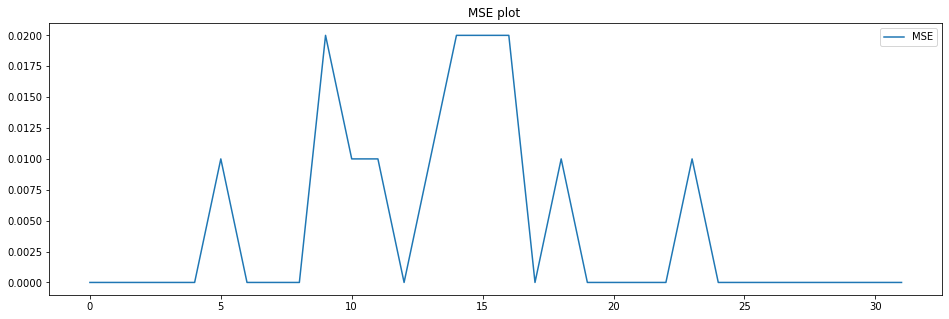


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 9
mean=0.002,median=0.0 ,max=0.02,min=0.0,variance=0.0


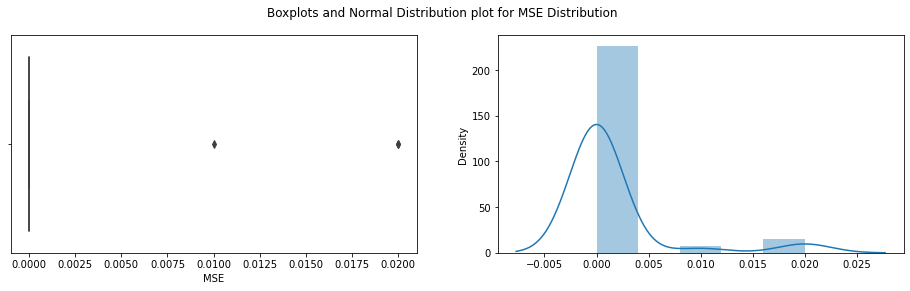

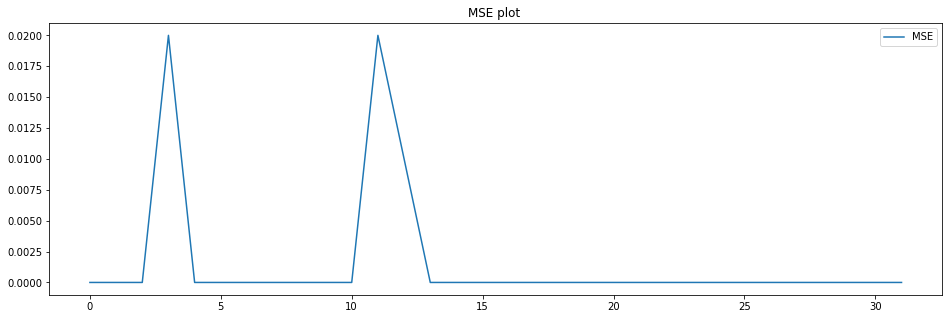


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 10
mean=0.001,median=0.0 ,max=0.02,min=0.0,variance=0.0


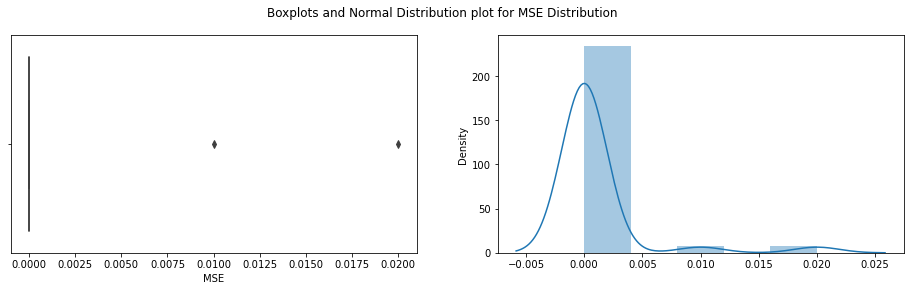

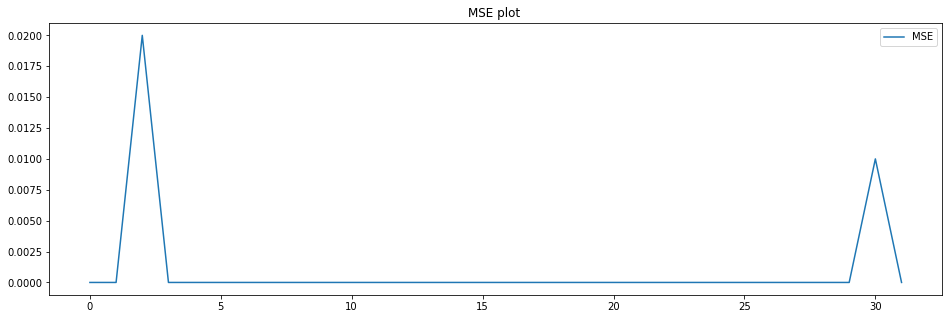


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 11
mean=0.001,median=0.0 ,max=0.01,min=0.0,variance=0.0


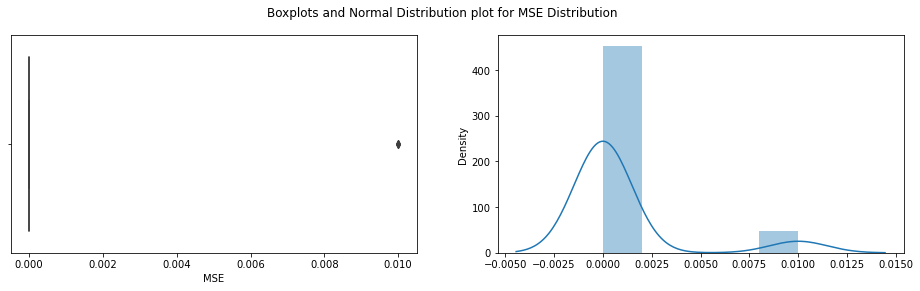

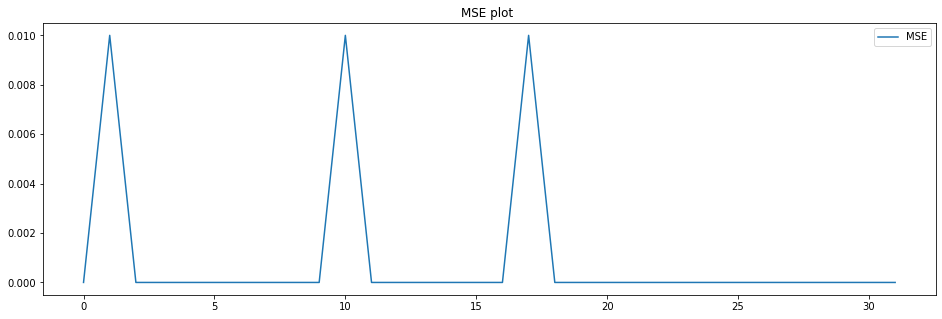


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 12
mean=0.001,median=0.0 ,max=0.01,min=0.0,variance=0.0


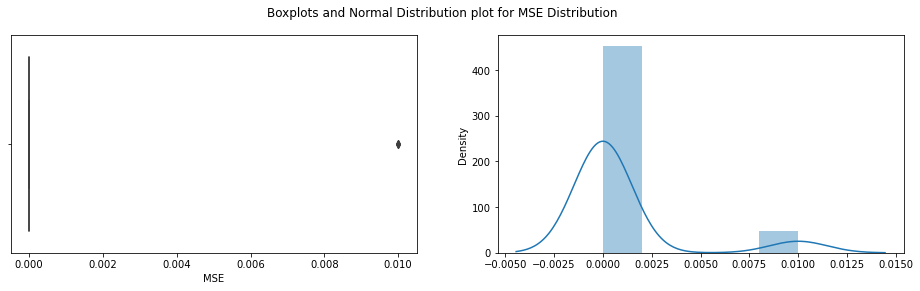

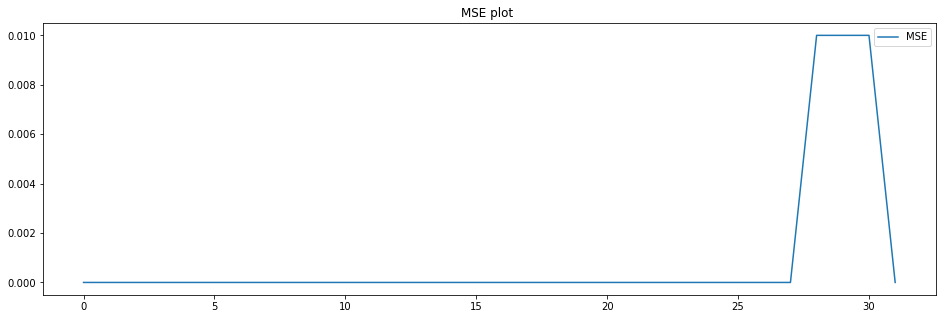


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 13
mean=0.0,median=0.0 ,max=0.0,min=0.0,variance=0.0


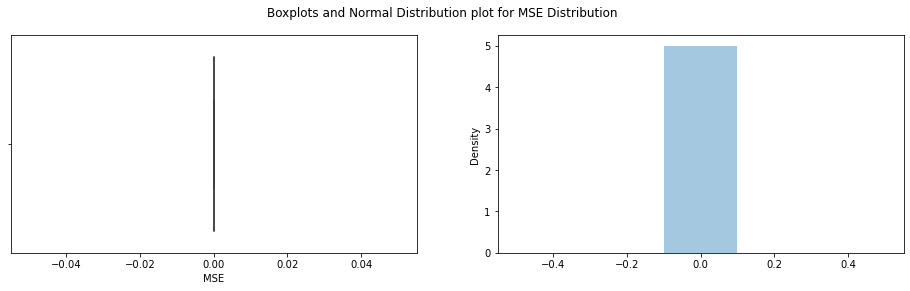

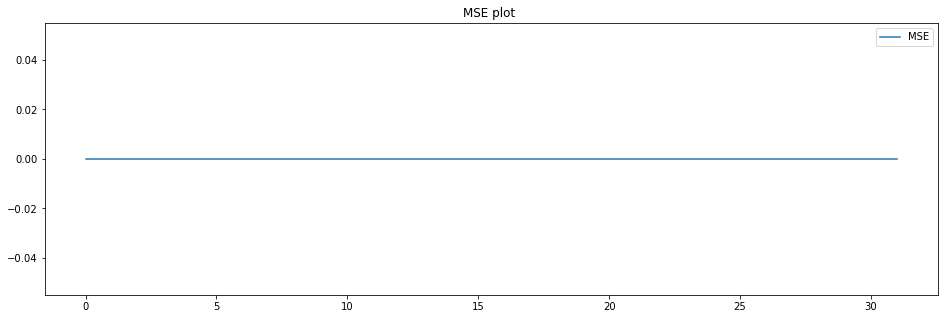


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 14
mean=0.001,median=0.0 ,max=0.01,min=0.0,variance=0.0


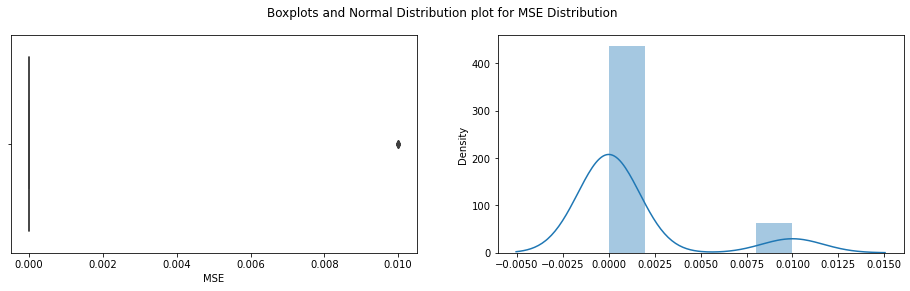

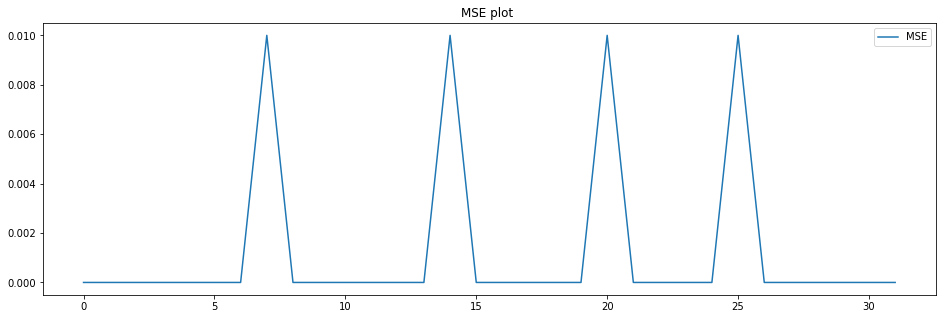


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 15
mean=0.004,median=0.0 ,max=0.03,min=0.0,variance=0.0


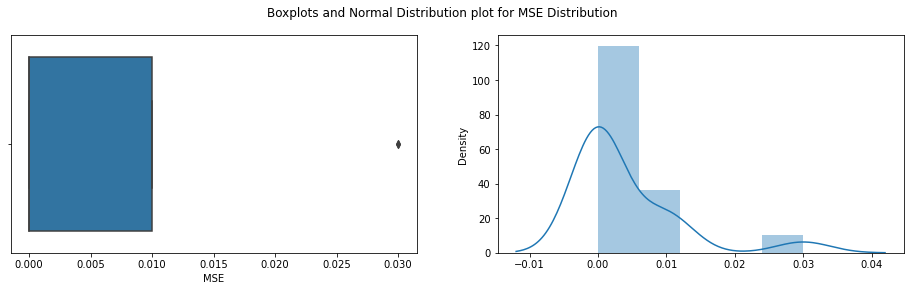

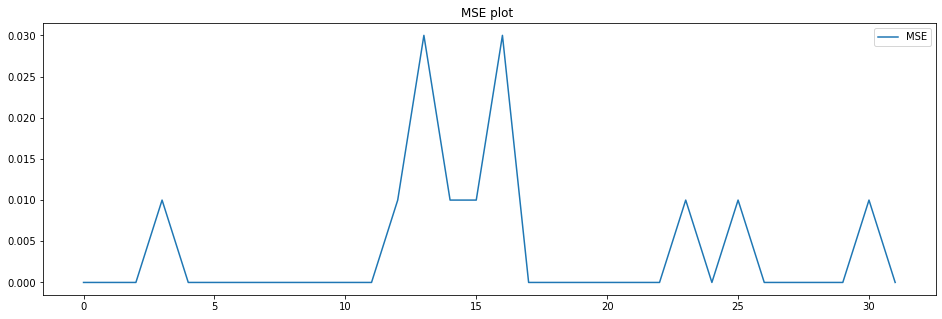


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 16
mean=0.002,median=0.0 ,max=0.02,min=0.0,variance=0.0


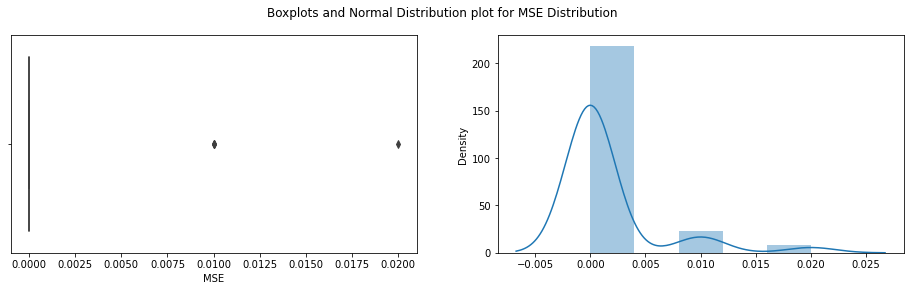

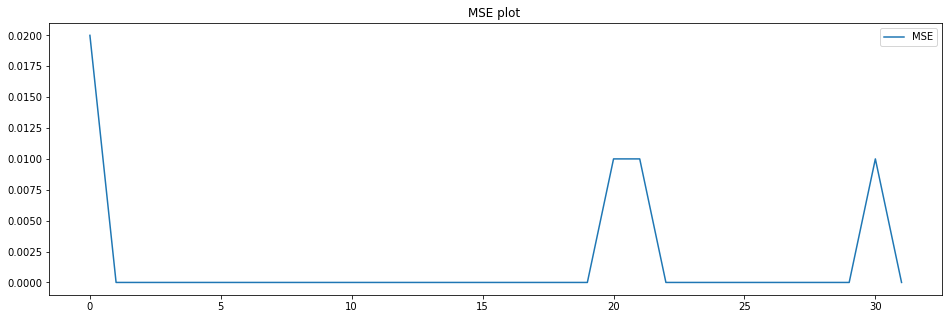


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 17
mean=0.001,median=0.0 ,max=0.01,min=0.0,variance=0.0


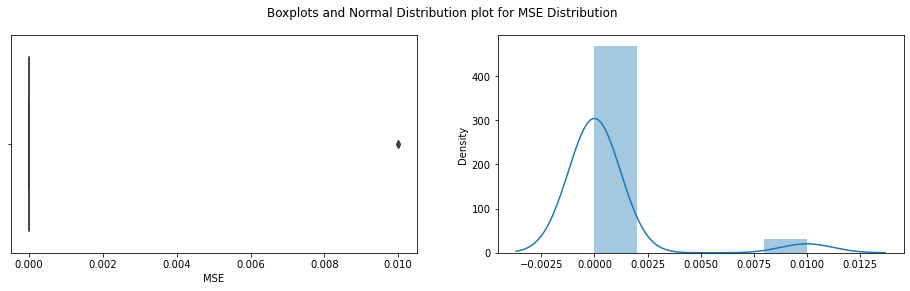

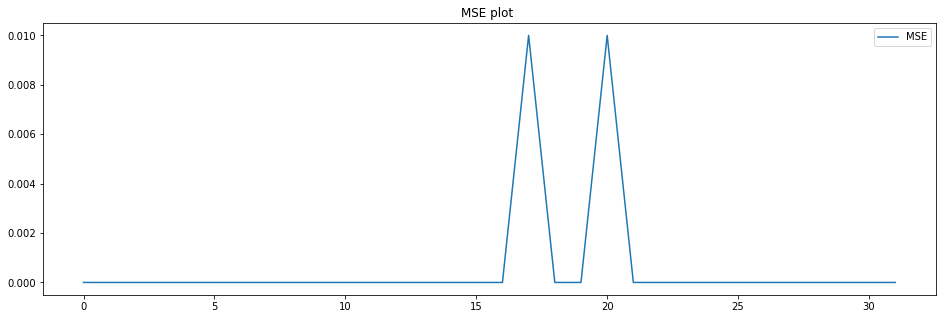


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 18
mean=0.0,median=0.0 ,max=0.01,min=0.0,variance=0.0


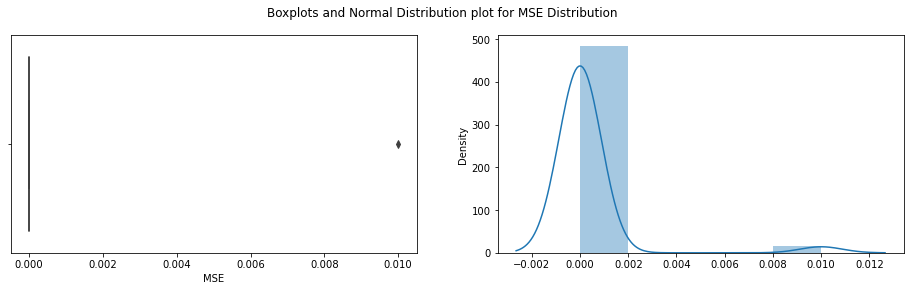

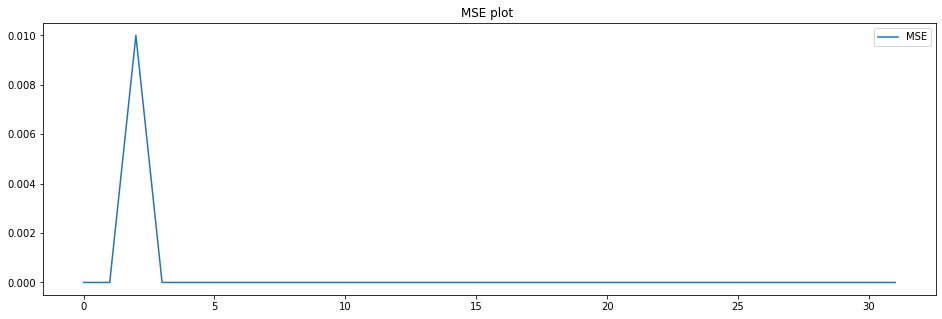


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 19
mean=0.001,median=0.0 ,max=0.01,min=0.0,variance=0.0


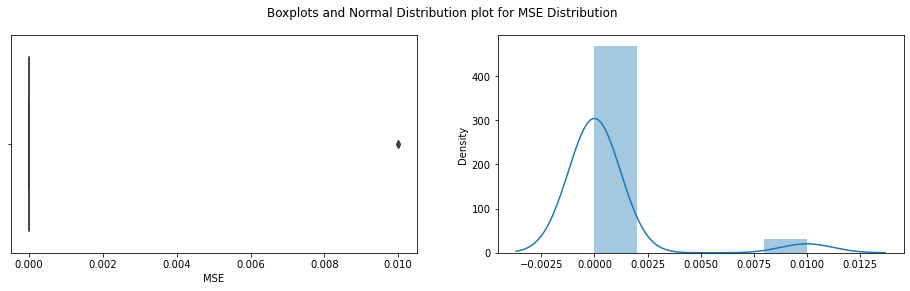

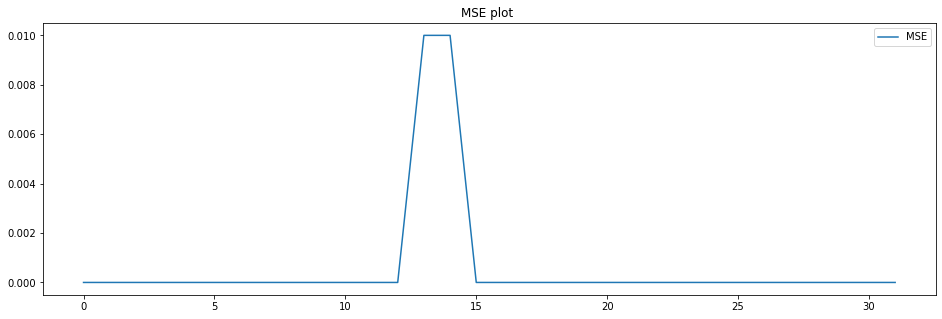


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 20
mean=0.0,median=0.0 ,max=0.0,min=0.0,variance=0.0


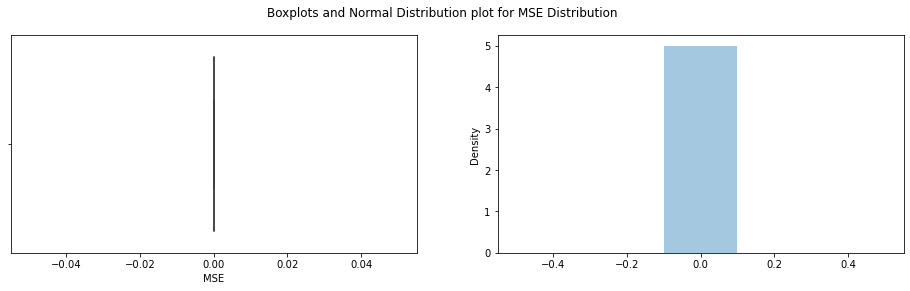

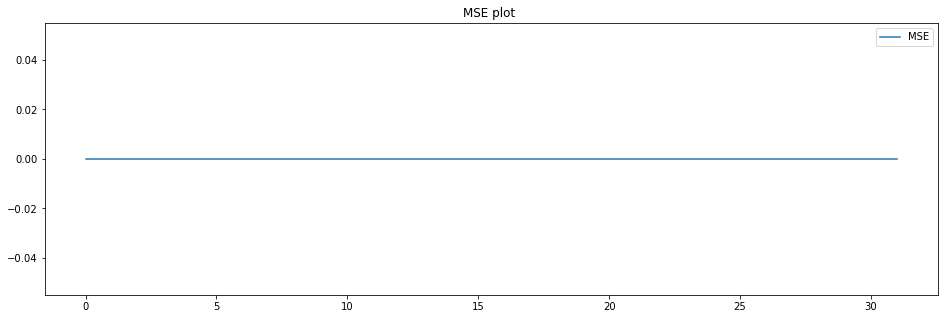


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 21
mean=0.002,median=0.0 ,max=0.01,min=0.0,variance=0.0


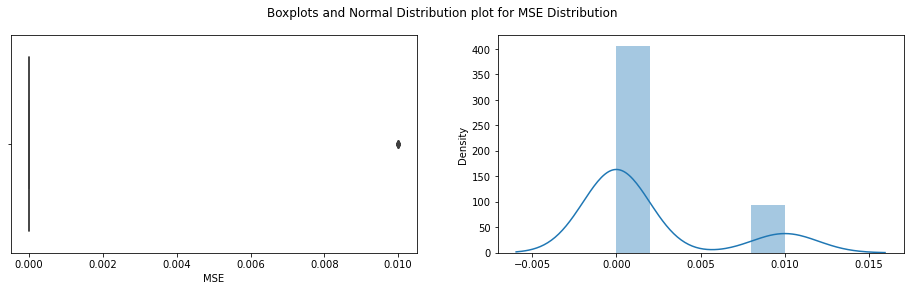

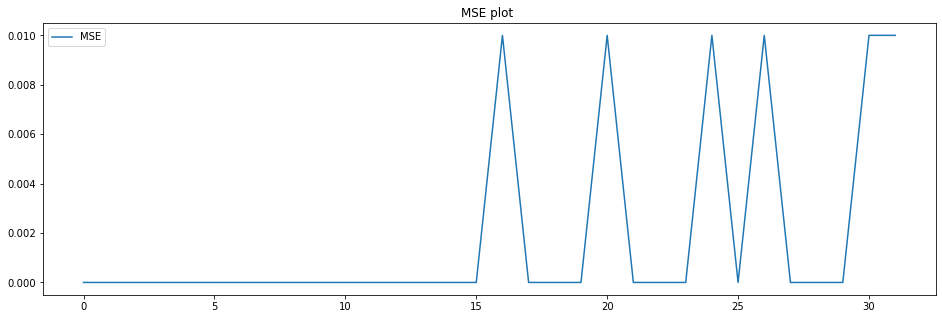


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 22
mean=0.003,median=0.0 ,max=0.01,min=0.0,variance=0.0


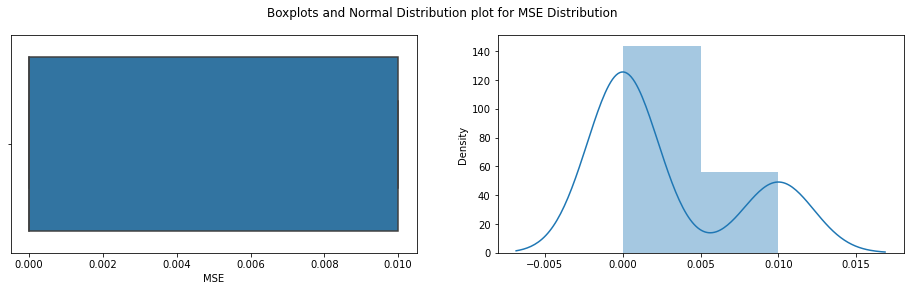

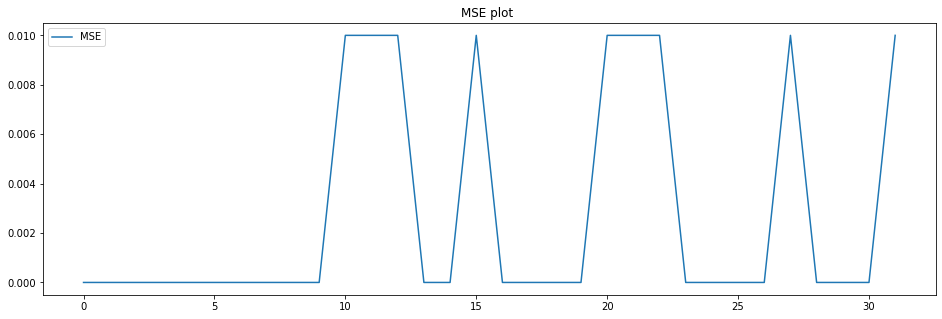


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 23
mean=0.006,median=0.0 ,max=0.04,min=0.0,variance=0.0


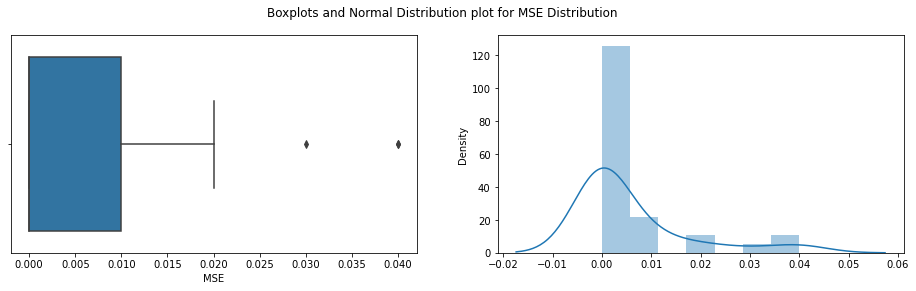

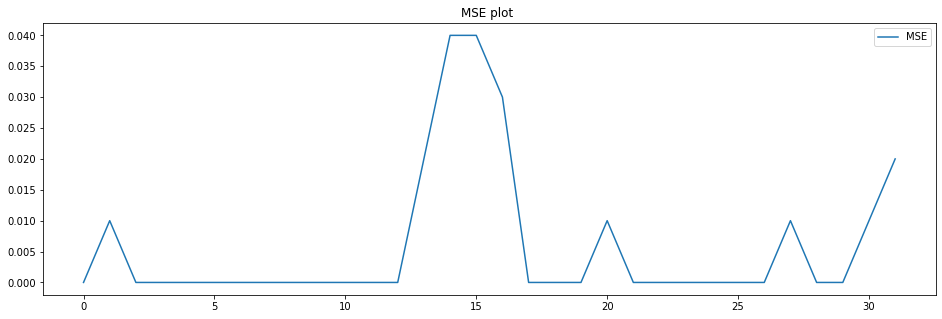


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 24
mean=0.002,median=0.0 ,max=0.01,min=0.0,variance=0.0


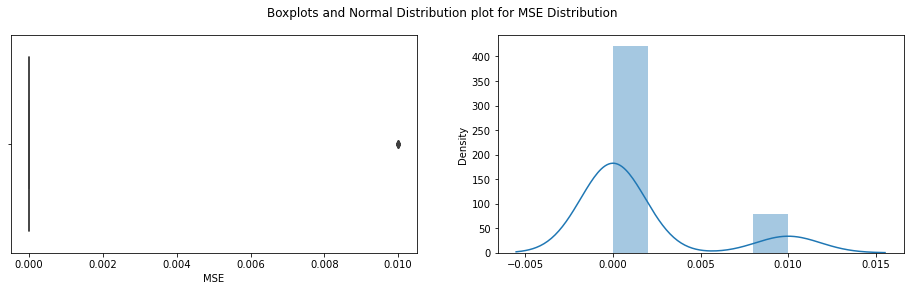

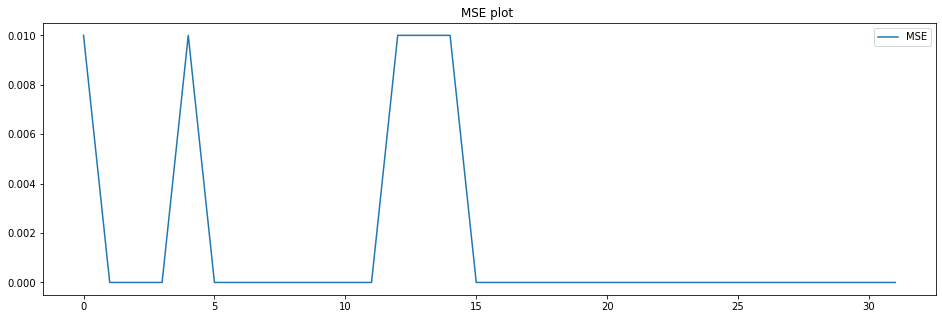


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 25
mean=0.001,median=0.0 ,max=0.01,min=0.0,variance=0.0


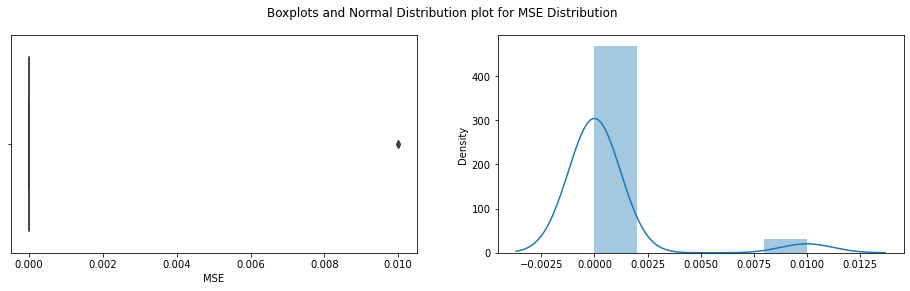

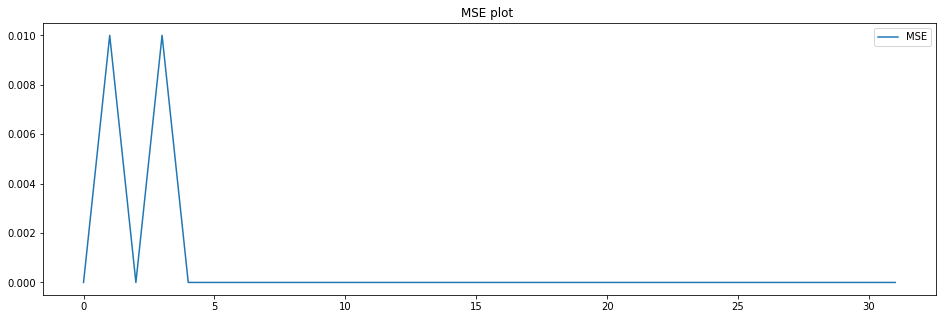


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 26
mean=0.0,median=0.0 ,max=0.01,min=0.0,variance=0.0


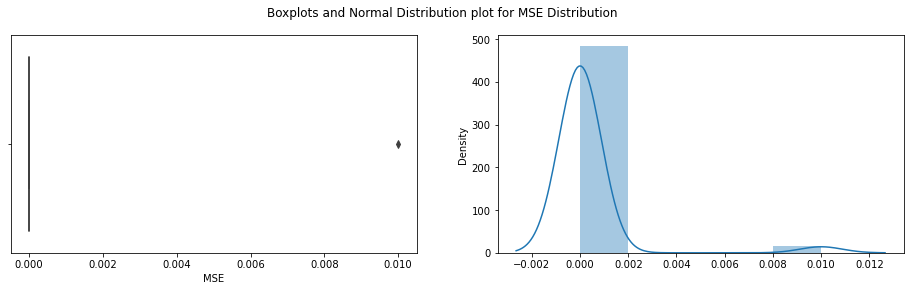

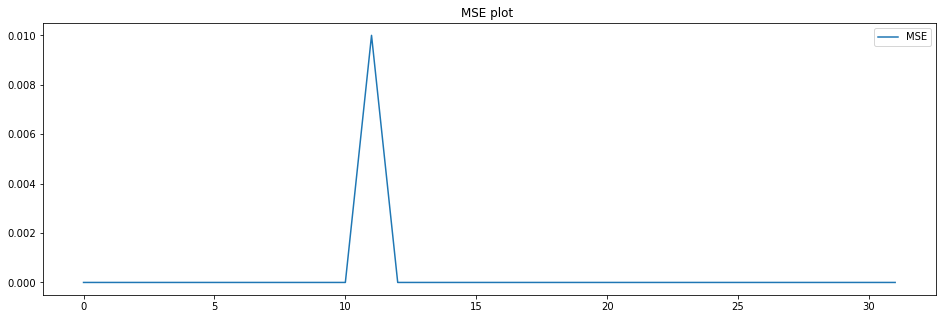


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 27
mean=0.002,median=0.0 ,max=0.02,min=0.0,variance=0.0


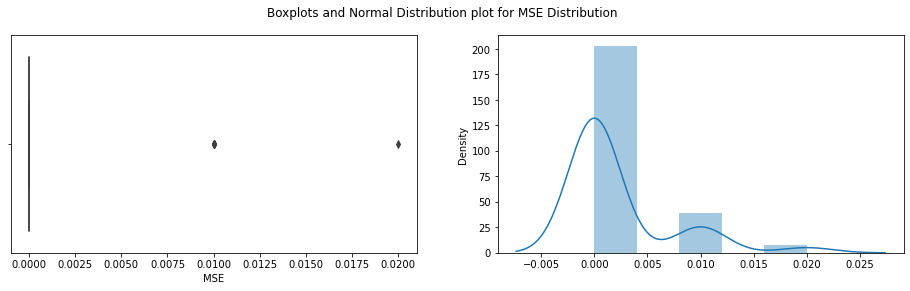

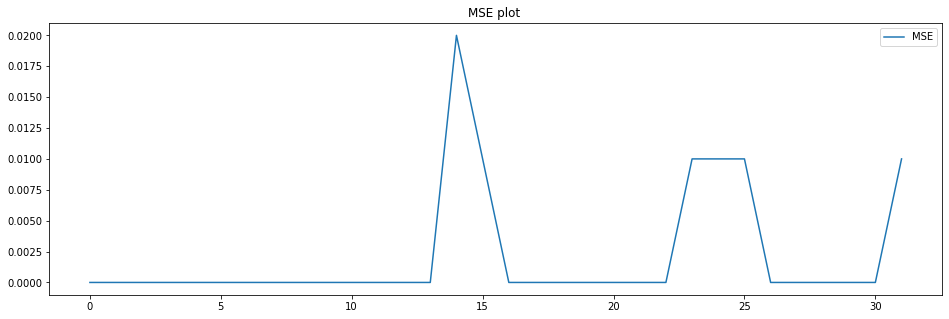


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 28
mean=0.002,median=0.0 ,max=0.02,min=0.0,variance=0.0


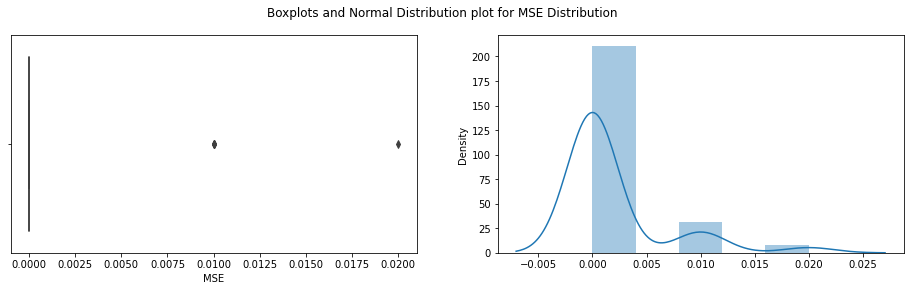

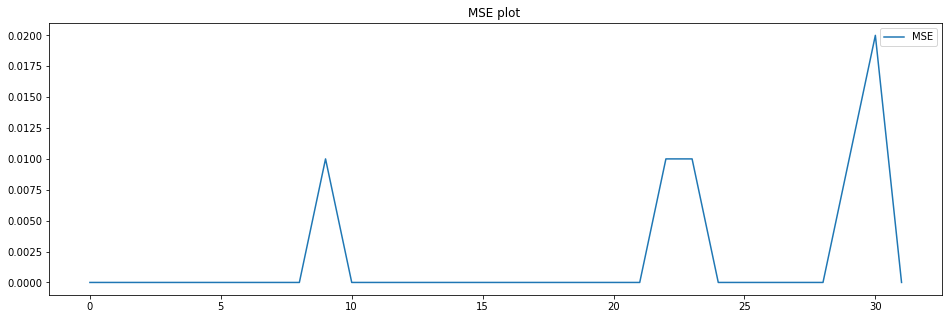


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 29
mean=0.001,median=0.0 ,max=0.01,min=0.0,variance=0.0


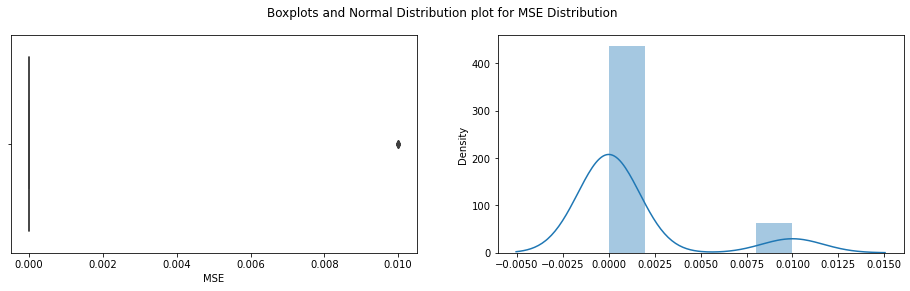

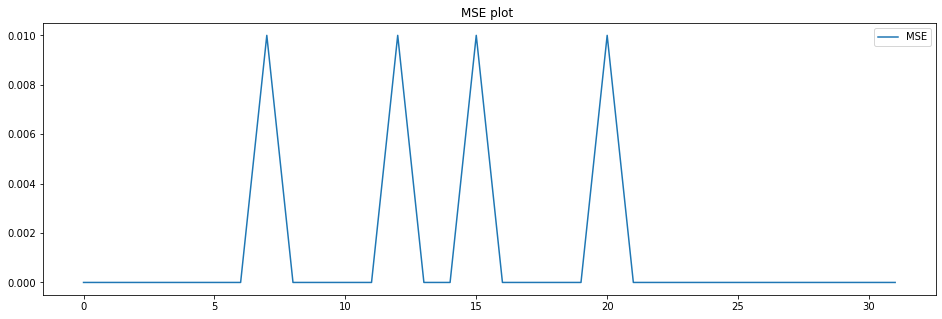


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 30
mean=0.001,median=0.0 ,max=0.01,min=0.0,variance=0.0


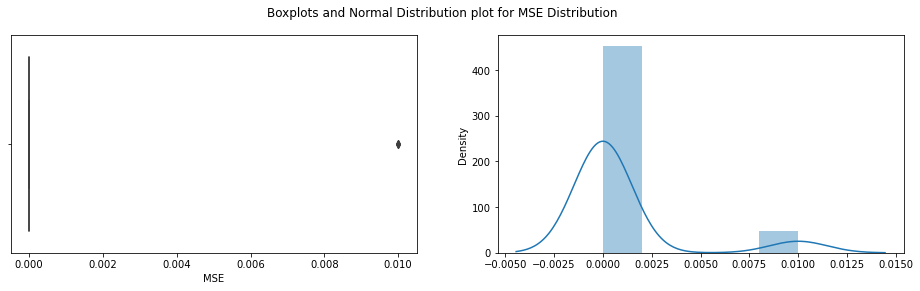

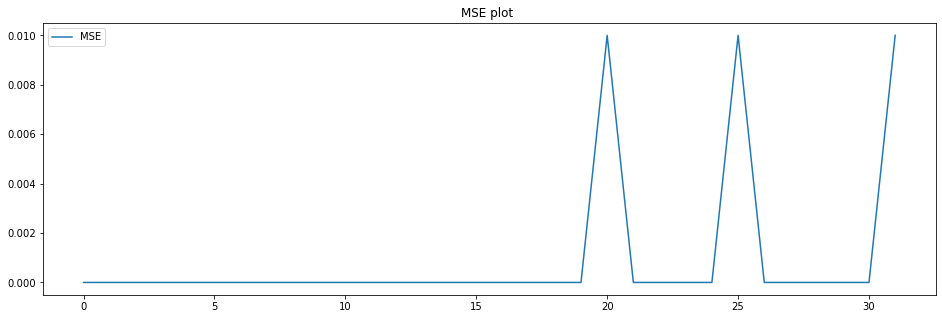


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 31
mean=0.001,median=0.0 ,max=0.02,min=0.0,variance=0.0


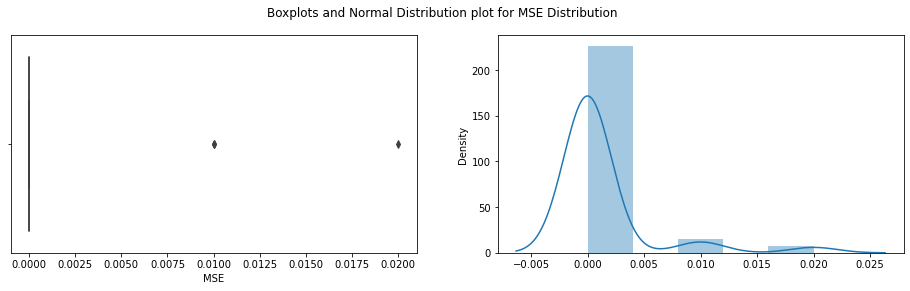

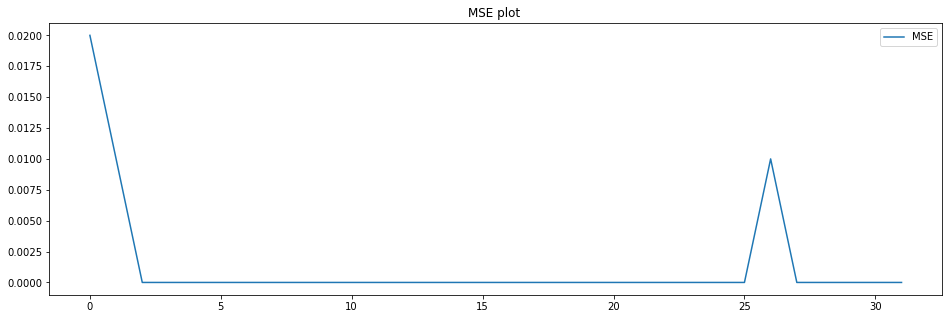


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 32
mean=0.001,median=0.0 ,max=0.01,min=0.0,variance=0.0


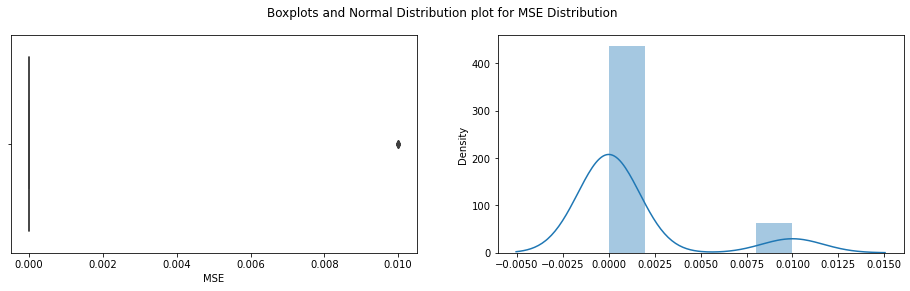

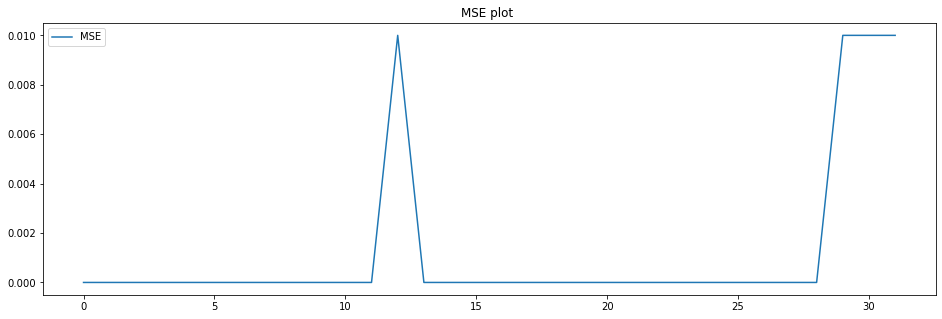


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 33
mean=0.002,median=0.0 ,max=0.02,min=0.0,variance=0.0


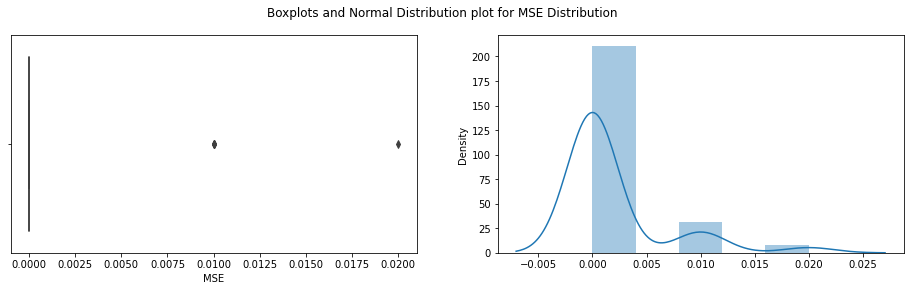

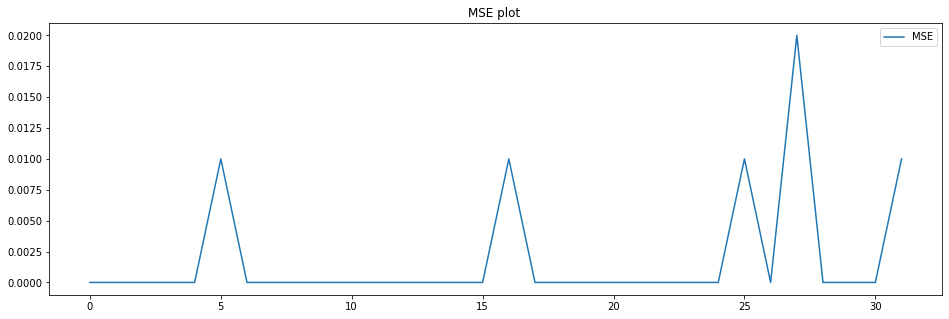


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 34
mean=0.002,median=0.0 ,max=0.01,min=0.0,variance=0.0


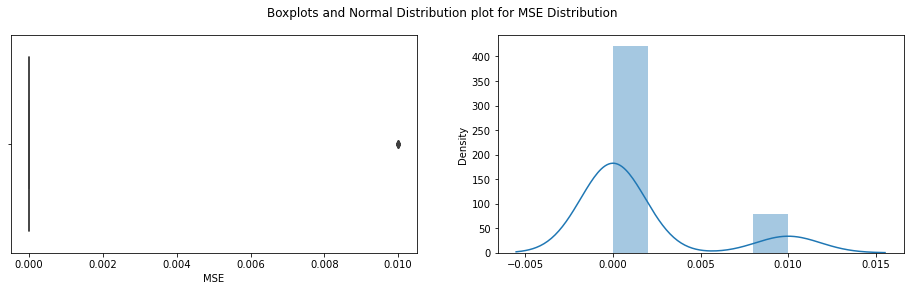

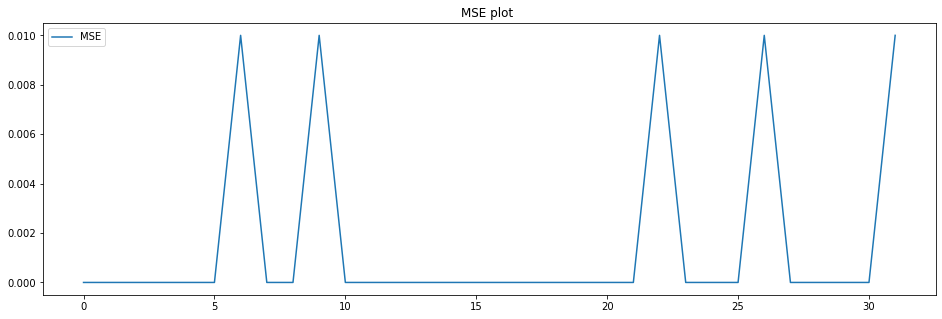


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 35
mean=0.001,median=0.0 ,max=0.01,min=0.0,variance=0.0


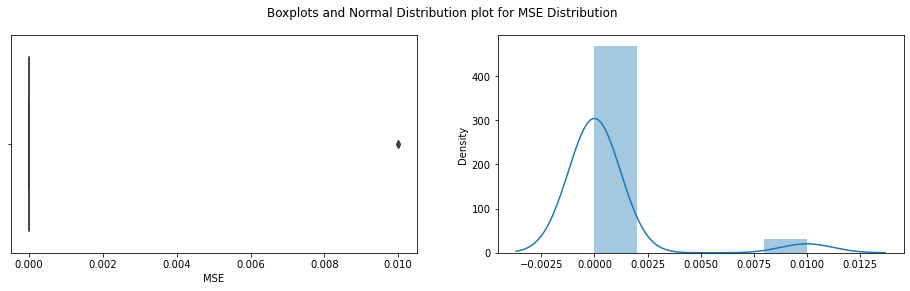

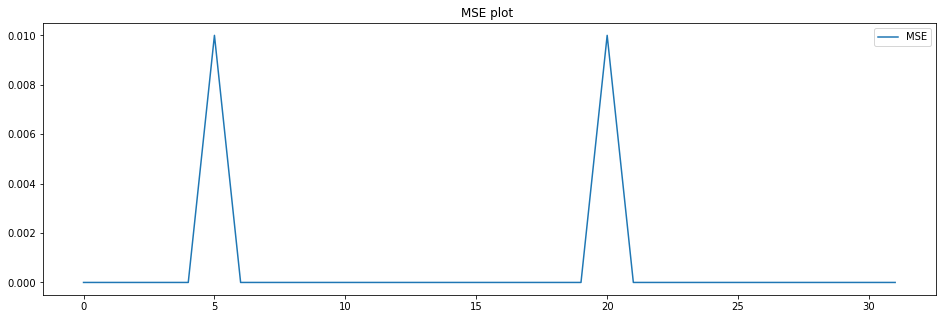


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 36
mean=0.008,median=0.0 ,max=0.04,min=0.0,variance=0.0


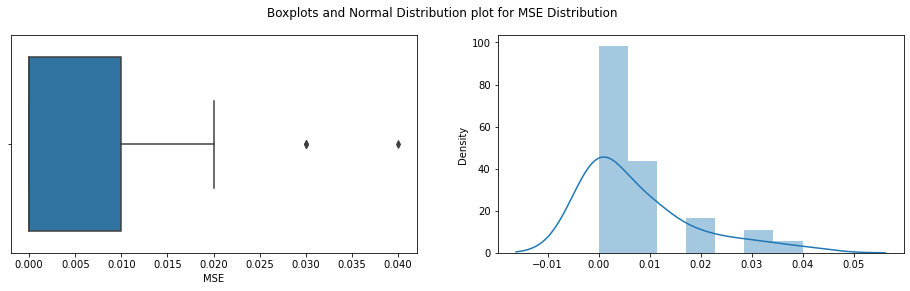

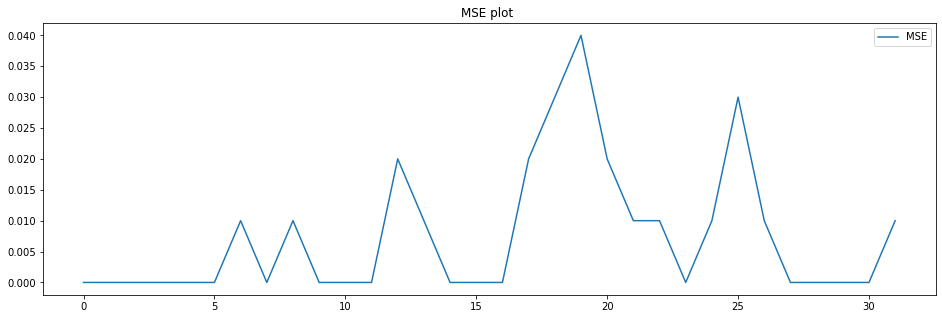


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 37
mean=0.0,median=0.0 ,max=0.0,min=0.0,variance=0.0


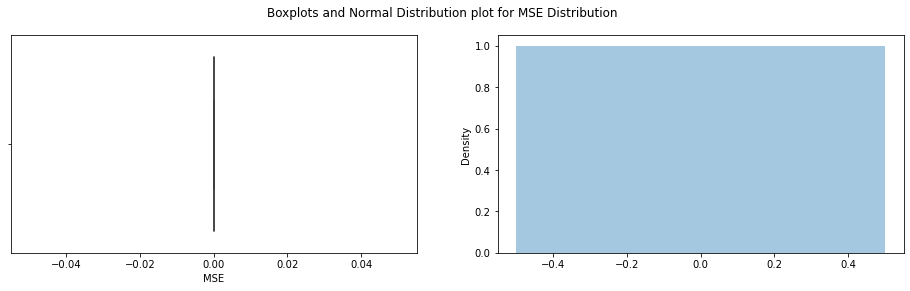

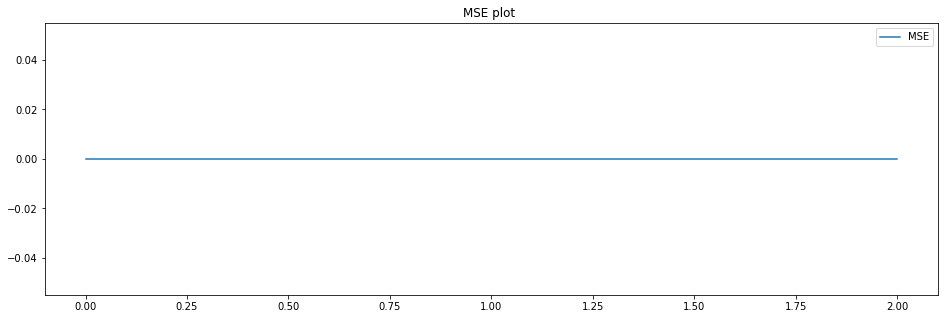


Shapiro_Wilk Test

Anderson_Darling Test


In [34]:
batch_avg_mse_neg_en_neg,batch_mse_values_neg_en_neg=check_all_batch_normality(batches_neg,encoder_neg_class,32)

In [35]:
batch_avg_mse_neg_en_neg;

In [36]:
def compute_instance_threshold_firstN_batches(batch_avg_mse_values,N):
    zscore_list=[]
    #value_list=[]
    for k in range(0,N):
        value_list=batch_avg_mse_values[k]
         #Z_SCORE
        mean=np.mean(value_list)
        sigma=np.std(value_list)
        thres_zscore=(mean+3*sigma).round(4)
        zscore_list.append(thres_zscore)
        #print (value_list)
        #print(zscore_list)
    return (np.mean(zscore_list).round(4)) , zscore_list  

In [37]:
instance_thresh_neg,zscore_list_neg=compute_instance_threshold_firstN_batches(batch_mse_values_neg_en_neg,10)

In [38]:
instance_thresh_neg

0.0104

In [39]:
## computes loss threshold uisng IQR as well as ZScore from first test batch 
def compute_loss_threshold_testdata(threshold_batch):
    #val_loss=history['val_loss']
    ## Quartile Method 
    Q1=np.quantile(threshold_batch,0.25)
    Q3=np.quantile(threshold_batch,0.75)
    IQR=Q3-Q1
    thres_iqr=(Q3+1.5*IQR).round(4)
    #Z_SCORE
    mean=np.mean(threshold_batch)
    sigma=np.std(threshold_batch)
    thres_zscore=(mean+3*sigma).round(4)
    
    return thres_iqr ,thres_zscore

In [40]:
## computes loss threshold uisng IQR as well as ZScore from first test batch 
def compute_batch_threshold_testdata(batch_avg_mse):
    #val_loss=history['val_loss']
    ## Quartile Method 
    Q1=np.quantile(batch_avg_mse,0.25)
    Q3=np.quantile(batch_avg_mse,0.75)
    IQR=Q3-Q1
    thres_iqr=(Q3 + 1.5*IQR).round(4)
    #Z_SCORE
    mean=np.mean(batch_avg_mse)
    sigma=np.std(batch_avg_mse)
    thres_zscore=(mean+3*sigma).round(4)
    thresh_max=np.round((np.max(batch_avg_mse)),3)
    return thres_iqr, thres_zscore ,thresh_max

In [41]:
thres_iqr_batch_neg, thres_zscore_batch_neg ,thresh_max_batch_neg=compute_batch_threshold_testdata(batch_avg_mse_neg_en_neg)

In [42]:
thres_zscore_batch_neg

0.0073

In [43]:
def threshold_exceed_count(batch_mse_values, thr):
    exceed_count={}
    for key in batch_mse_values.keys():
        count=0
        list=batch_mse_values[key]
        for a in range(0,len(list)):
            if list[a]>thr:
                count+=1
        exceed_count[key]=count 
    values = exceed_count.values()
    total = sum(values)
    return exceed_count,total

In [44]:
# Counts the MSE values exceeding threshold in each batch 
exceed_count_neg_en_neg,total_neg_en_neg=threshold_exceed_count(batch_mse_values_neg_en_neg,instance_thresh_neg)

In [45]:
exceed_list_neg_en_neg=[]
for key in exceed_count_neg_en_neg.keys():
    exceed_list_neg_en_neg.append(exceed_count_neg_en_neg[key])

mean=1.342,median=1.0 ,max=9,min=0,variance=3.646


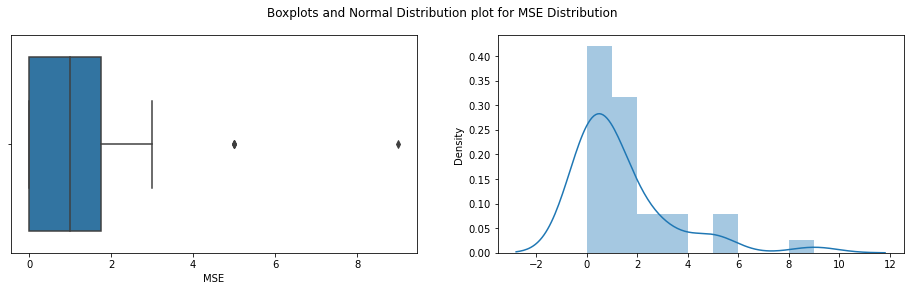

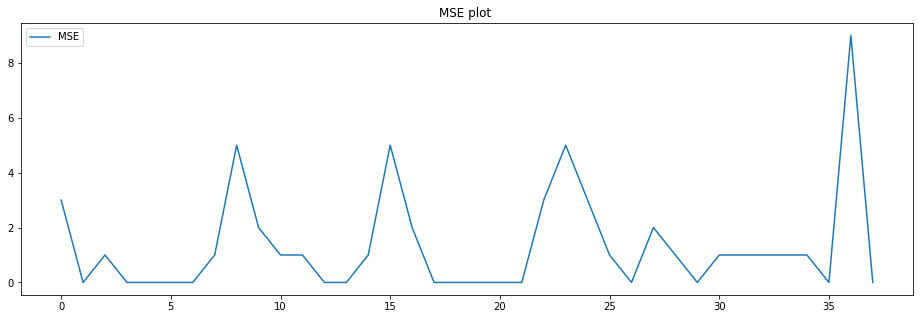

In [46]:
plot_results(exceed_list_neg_en_neg)

In [47]:
count_thresh_neg=np.max(exceed_list_neg_en_neg)

In [48]:
count_thresh_neg

9

## Positive AE

In [49]:
predictions_pos=mse_predictions(test_pos_class,encoder_pos_class)

mean=0.002,median=0.0 ,max=0.03,min=0.0,variance=0.0


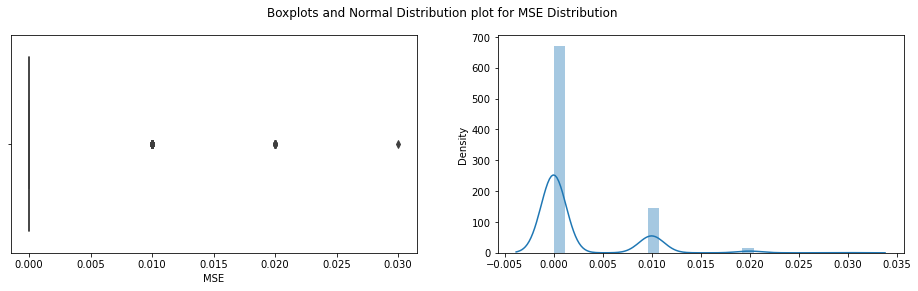

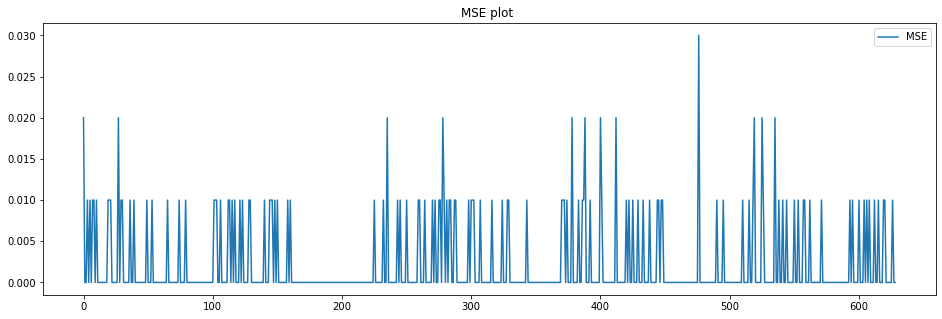

In [51]:
plot_results(predictions_pos)

In [52]:
batches_pos, batch_size=make_batches(test_pos_class)


 ********************
Batch: 0
mean=0.004,median=0.0 ,max=0.02,min=0.0,variance=0.0


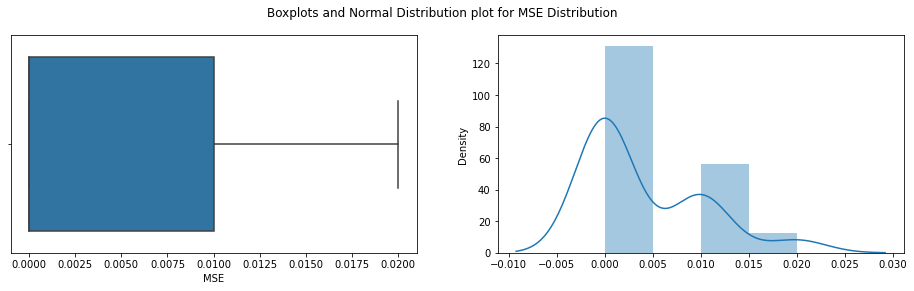

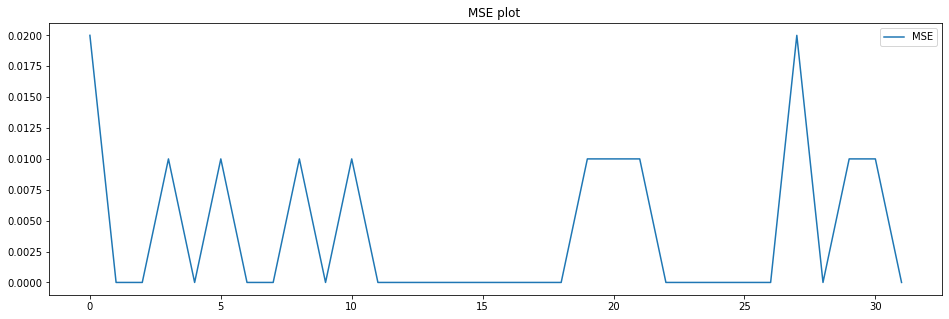


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 1
mean=0.001,median=0.0 ,max=0.01,min=0.0,variance=0.0


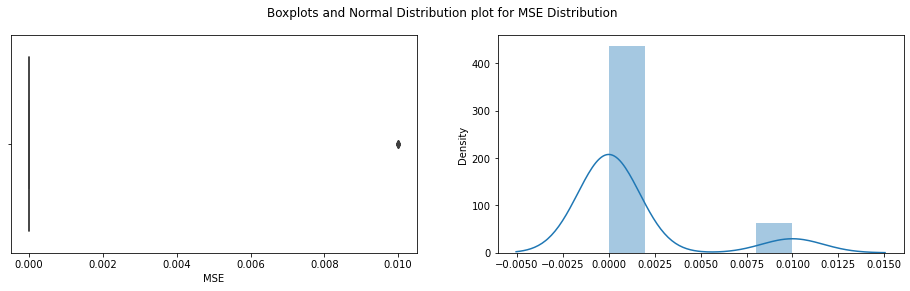

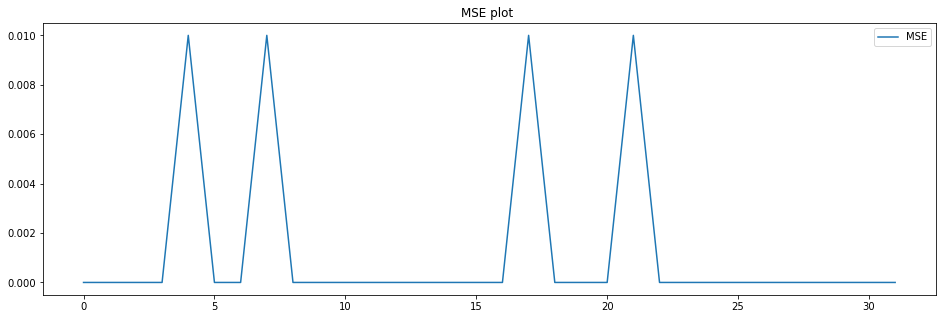


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 2
mean=0.001,median=0.0 ,max=0.01,min=0.0,variance=0.0


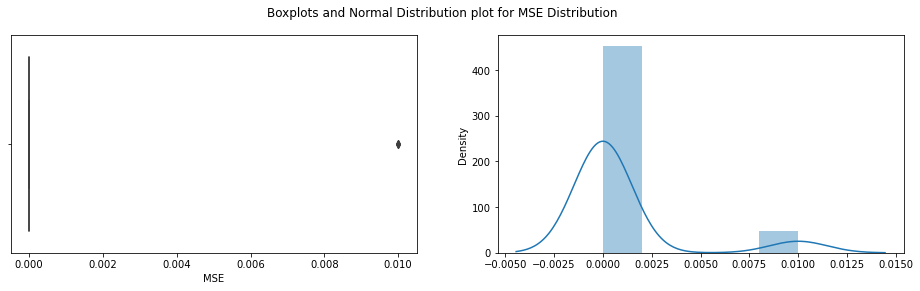

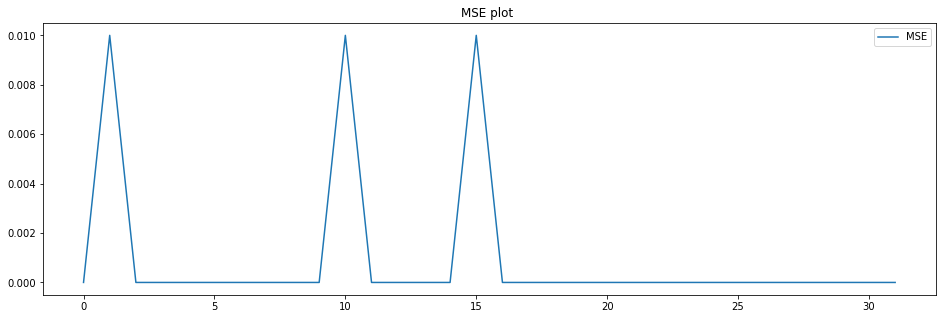


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 3
mean=0.003,median=0.0 ,max=0.01,min=0.0,variance=0.0


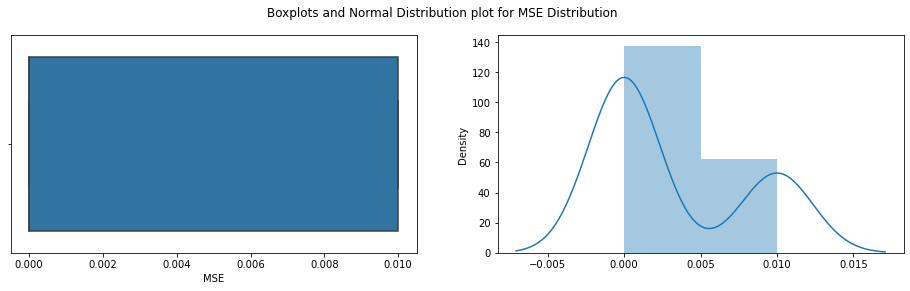

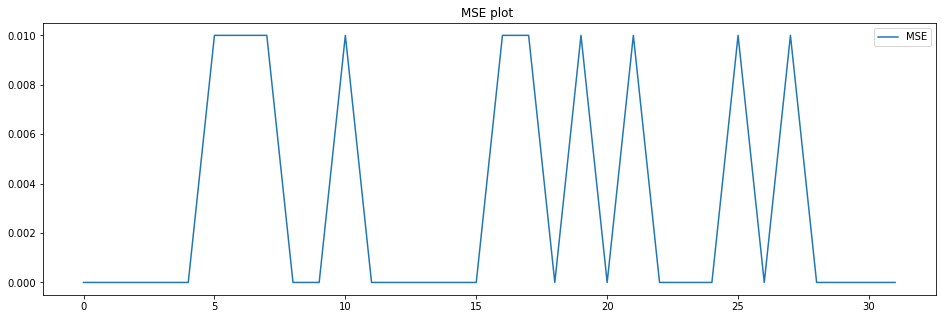


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 4
mean=0.003,median=0.0 ,max=0.01,min=0.0,variance=0.0


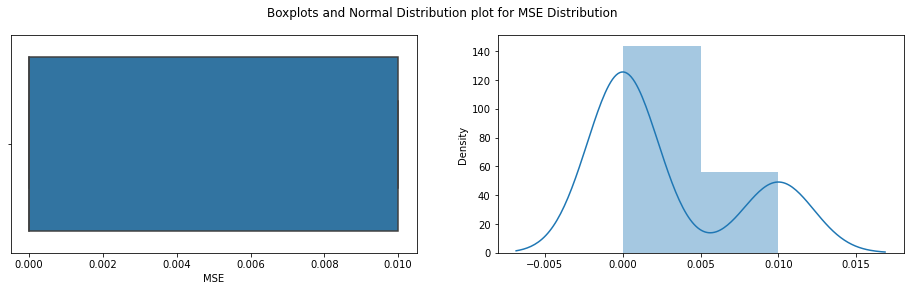

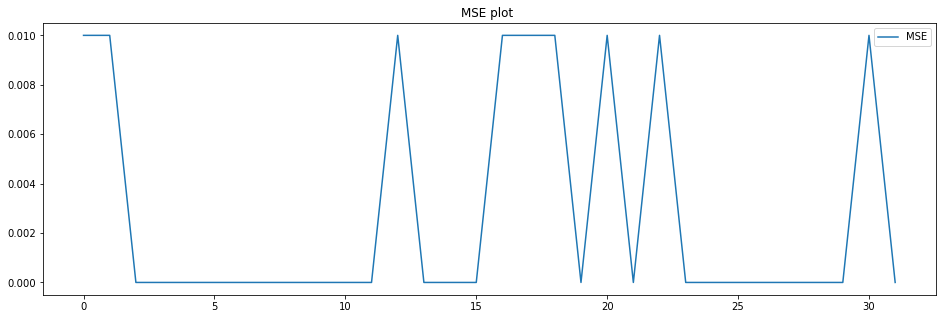


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 5
mean=0.0,median=0.0 ,max=0.01,min=0.0,variance=0.0


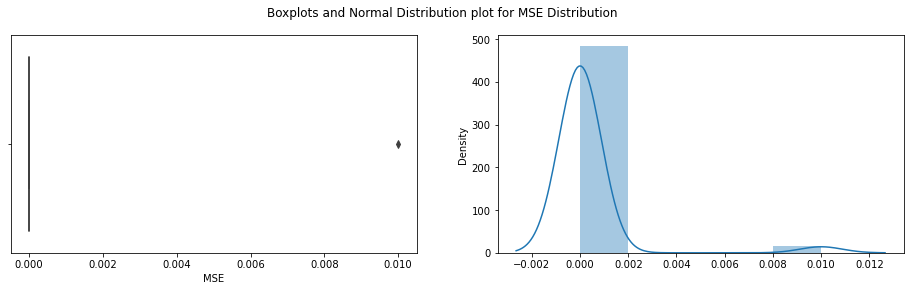

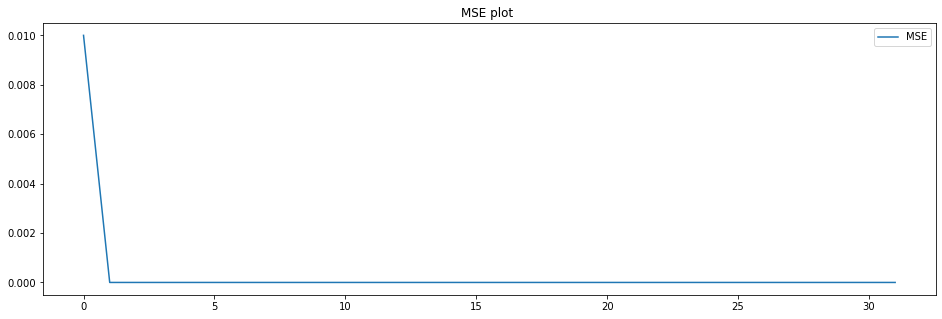


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 6
mean=0.0,median=0.0 ,max=0.0,min=0.0,variance=0.0


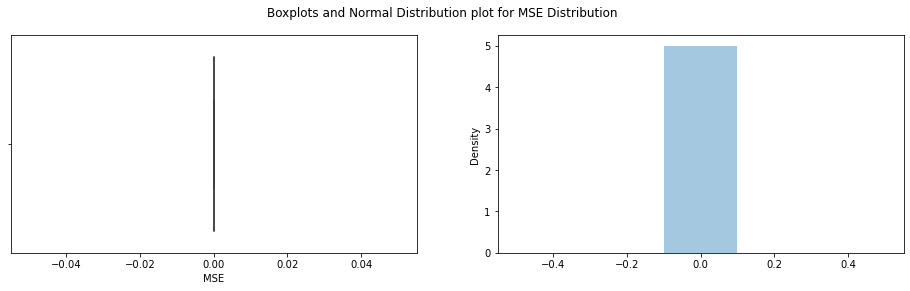

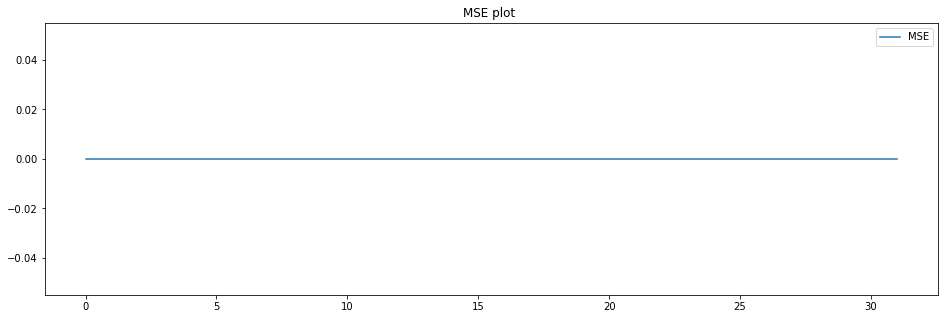


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 7
mean=0.002,median=0.0 ,max=0.02,min=0.0,variance=0.0


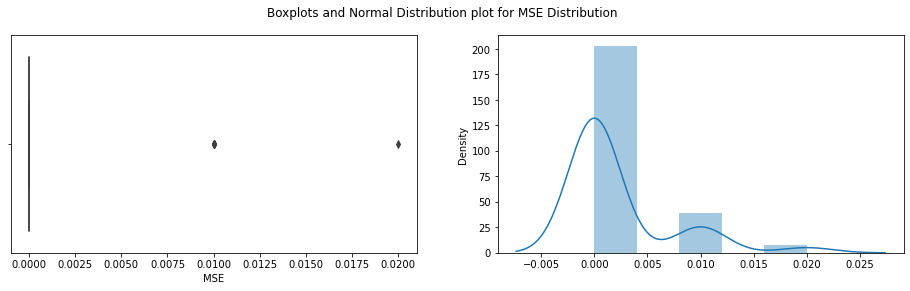

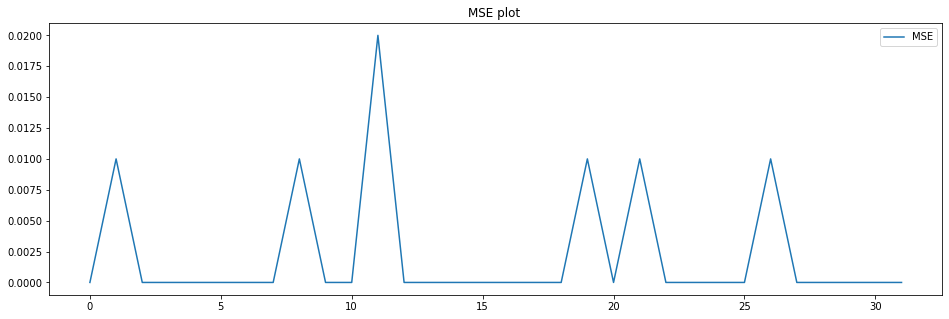


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 8
mean=0.004,median=0.0 ,max=0.02,min=0.0,variance=0.0


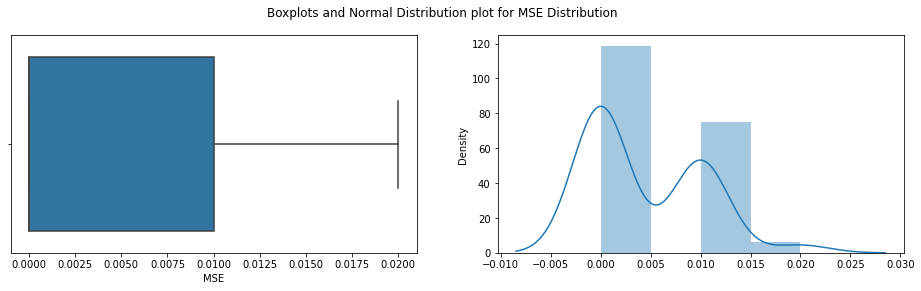

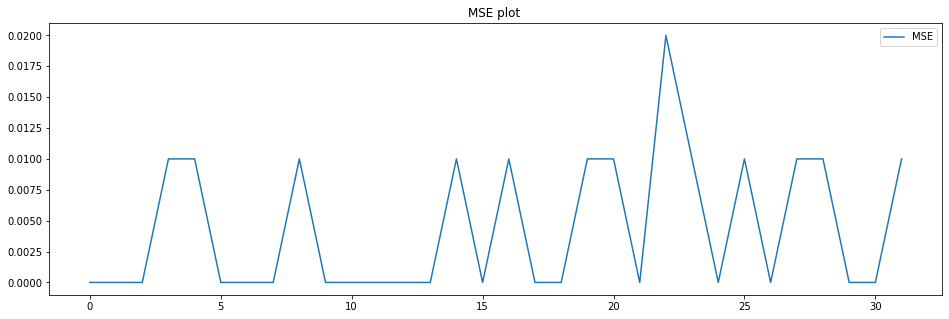


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 9
mean=0.002,median=0.0 ,max=0.01,min=0.0,variance=0.0


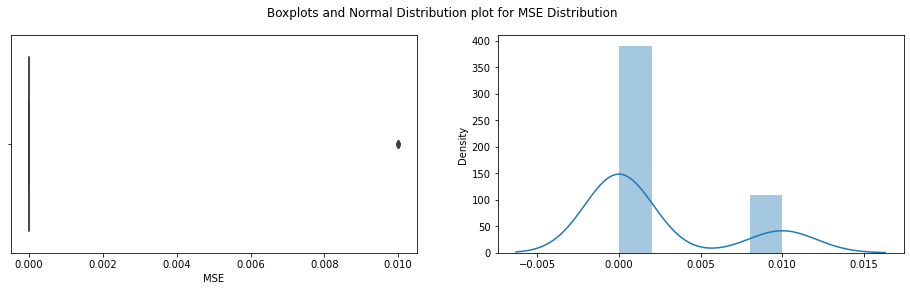

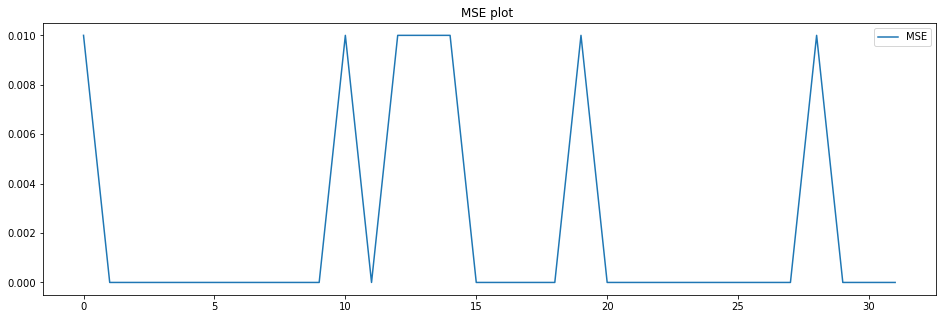


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 10
mean=0.001,median=0.0 ,max=0.01,min=0.0,variance=0.0


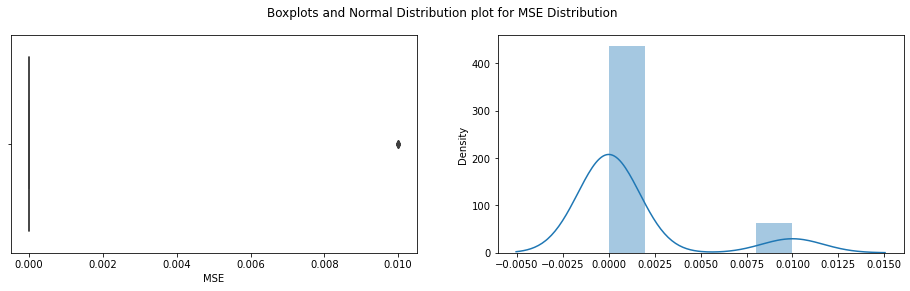

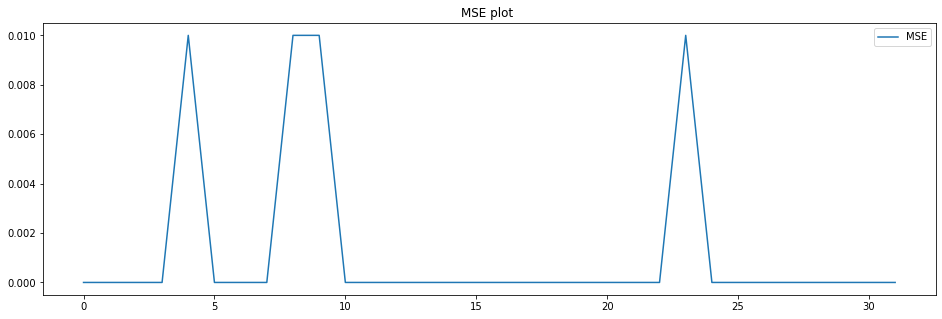


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 11
mean=0.002,median=0.0 ,max=0.02,min=0.0,variance=0.0


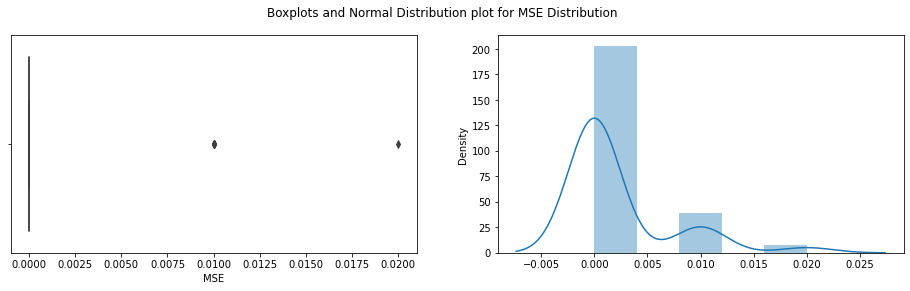

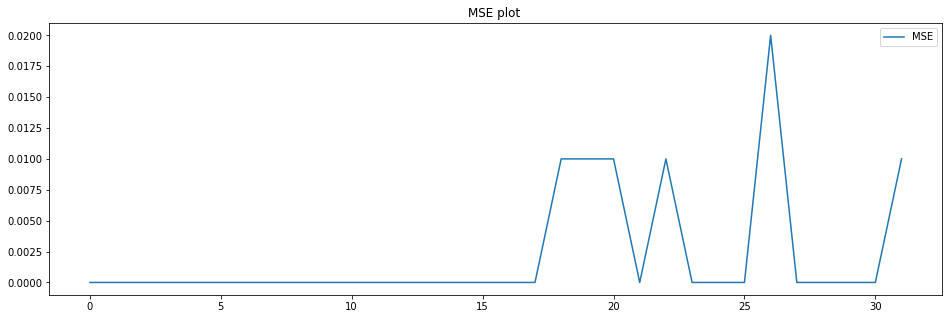


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 12
mean=0.003,median=0.0 ,max=0.02,min=0.0,variance=0.0


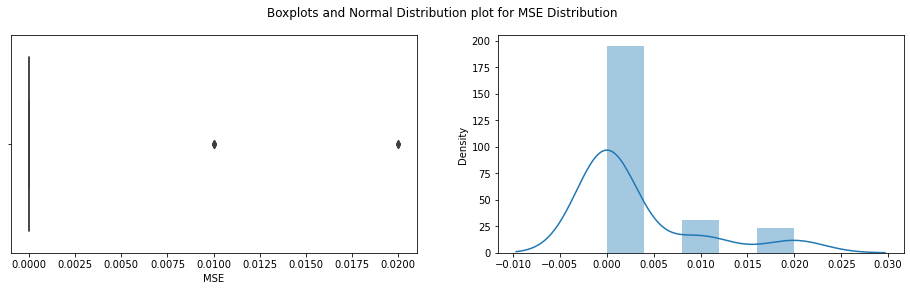

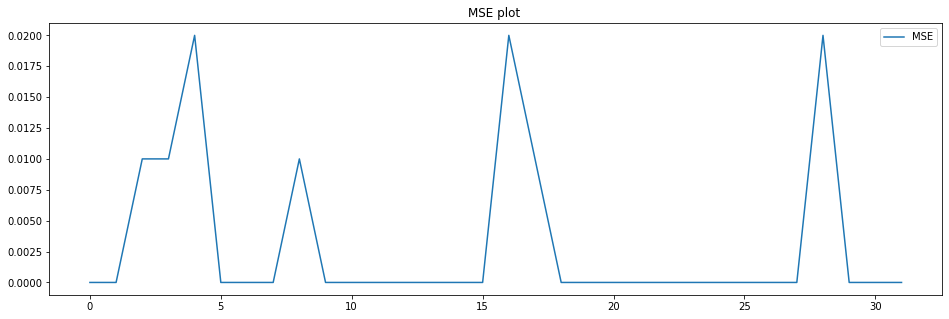


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 13
mean=0.002,median=0.0 ,max=0.01,min=0.0,variance=0.0


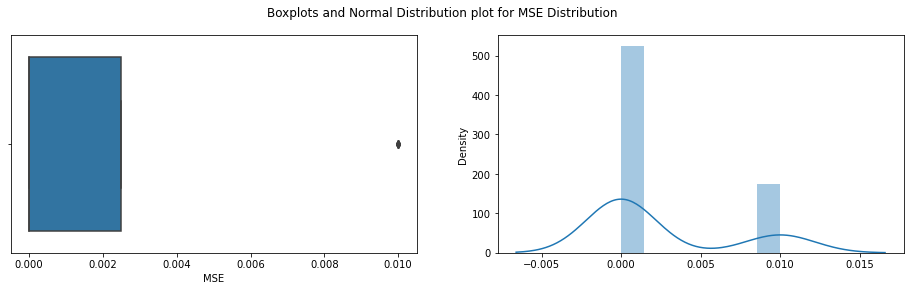

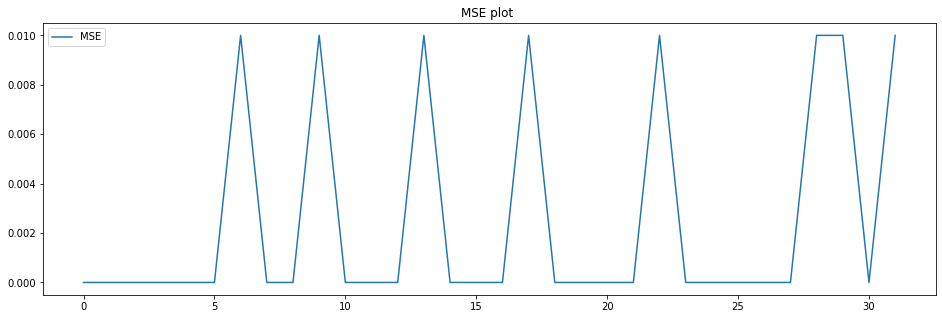


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 14
mean=0.001,median=0.0 ,max=0.03,min=0.0,variance=0.0


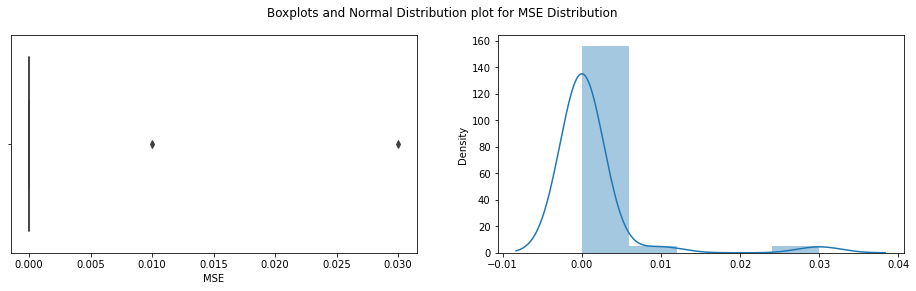

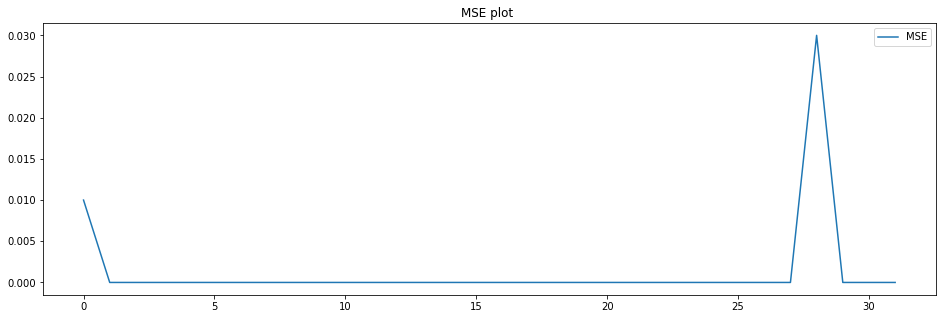


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 15
mean=0.001,median=0.0 ,max=0.01,min=0.0,variance=0.0


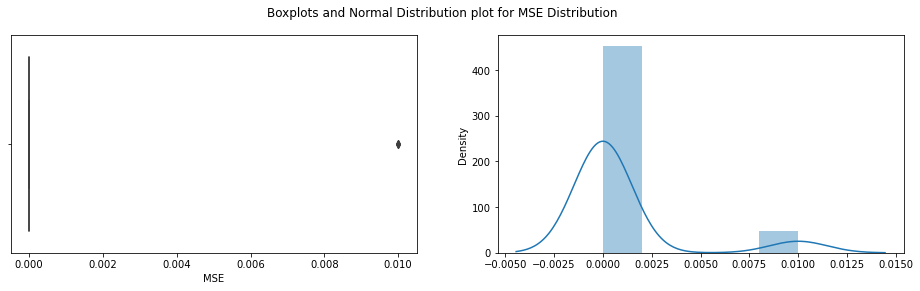

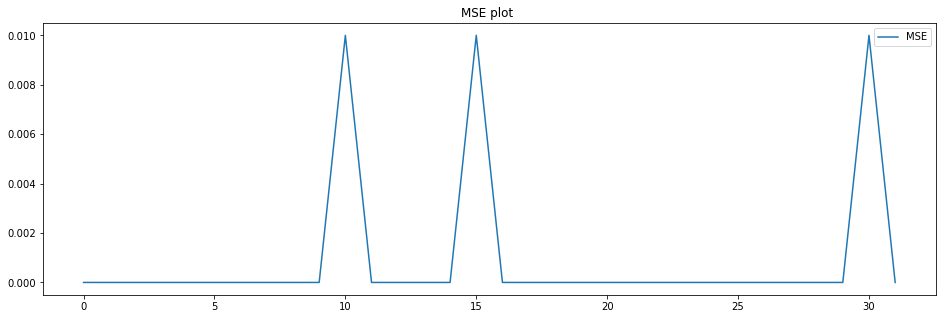


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 16
mean=0.003,median=0.0 ,max=0.02,min=0.0,variance=0.0


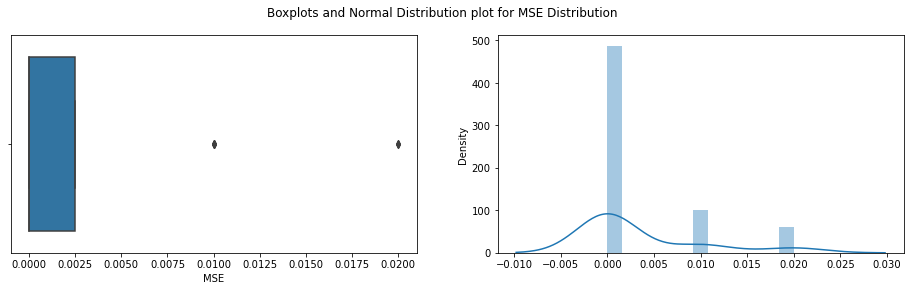

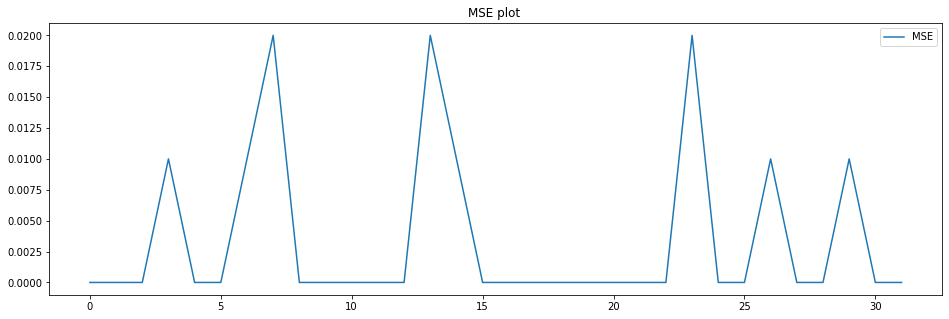


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 17
mean=0.002,median=0.0 ,max=0.01,min=0.0,variance=0.0


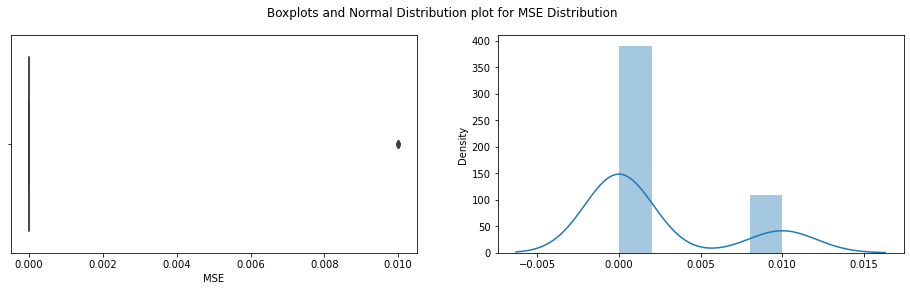

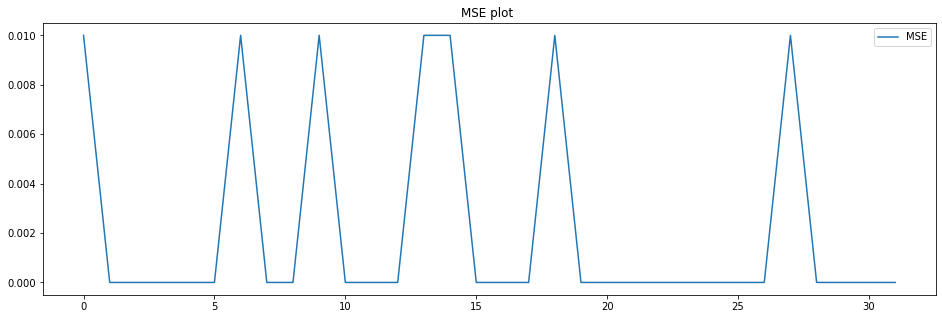


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 18
mean=0.002,median=0.0 ,max=0.01,min=0.0,variance=0.0


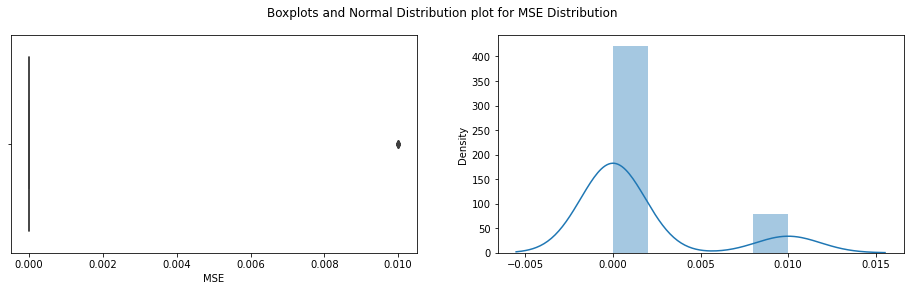

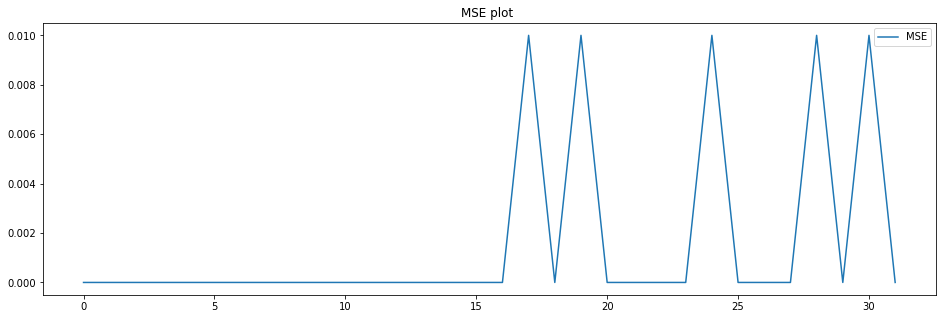


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 19
mean=0.003,median=0.0 ,max=0.01,min=0.0,variance=0.0


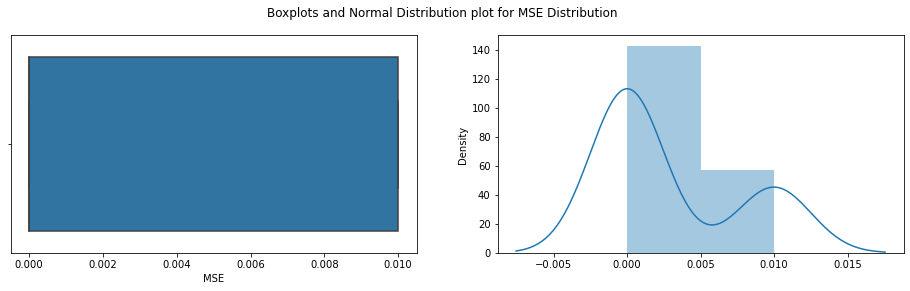

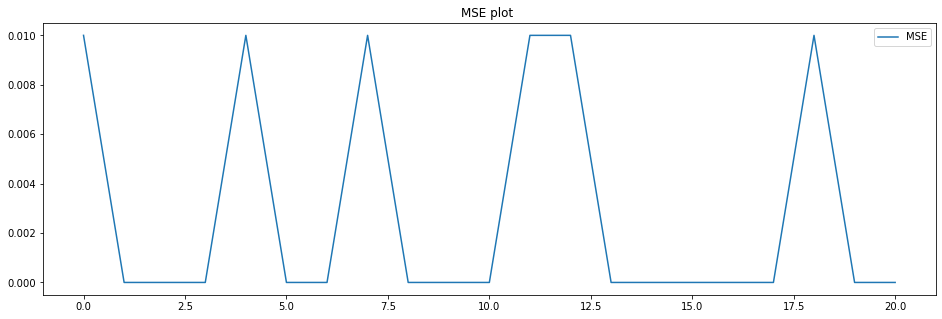


Shapiro_Wilk Test

Anderson_Darling Test


In [53]:
batch_avg_mse_pos,batch_mse_values_pos=check_all_batch_normality(batches_pos,encoder_pos_class,32)

In [54]:
instance_thresh_pos,zscore_list_pos=compute_instance_threshold_firstN_batches(batch_mse_values_pos,2)

In [55]:
instance_thresh_pos

0.0156

In [56]:
thres_iqr_batch_pos, thres_zscore_batch_pos ,thresh_max_batch_pos=compute_batch_threshold_testdata(batch_avg_mse_pos)

In [57]:
thres_zscore_batch_pos

0.0064

In [58]:
# Counts the MSE values exceeding threshold in each batch 
exceed_count_pos,total_pos=threshold_exceed_count(batch_mse_values_pos,instance_thresh_pos)

In [59]:
exceed_list_pos=[]
for key in exceed_count_pos.keys():
    exceed_list_pos.append(exceed_count_pos[key])

mean=0.55,median=0.0 ,max=3,min=0,variance=0.948


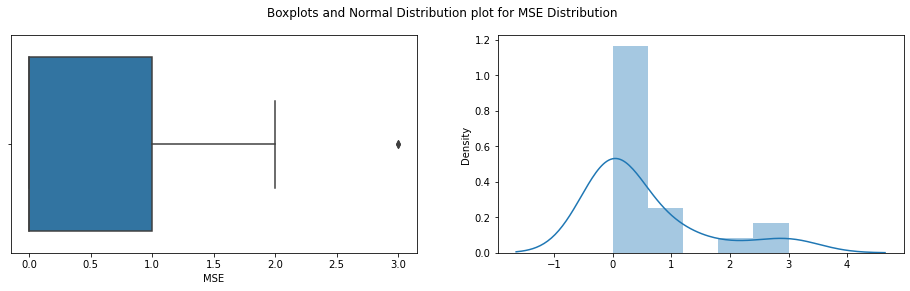

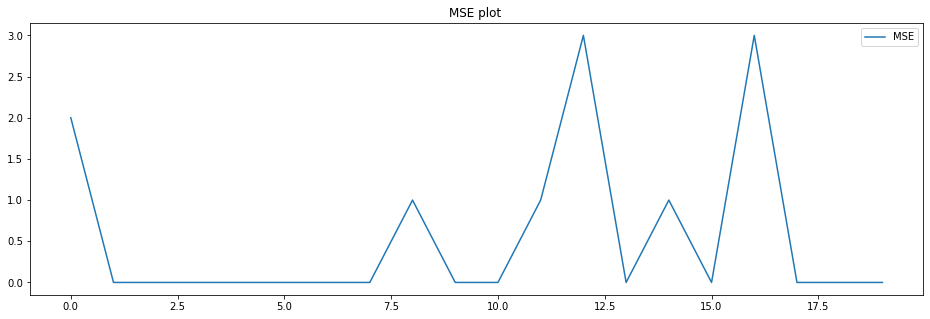

In [60]:
plot_results(exceed_list_pos)

In [61]:
count_thresh_pos=np.max(exceed_list_pos)

In [62]:
count_thresh_pos

3

# Drift Detection

In [63]:
df2=stream.copy()

In [64]:
df2

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,class
16343,0.352,0.472,0.008,0.137,0.222,0.191,0.338,0.399,1
16344,0.444,0.566,0.006,0.012,0.168,0.130,0.397,0.504,2
16345,0.466,0.572,0.006,0.137,0.158,0.210,0.448,0.515,2
16346,0.462,0.556,0.007,0.226,0.208,0.210,0.440,0.523,1
16347,0.376,0.477,0.008,0.210,0.201,0.170,0.347,0.429,1
...,...,...,...,...,...,...,...,...,...
18154,0.425,0.461,0.009,0.278,0.441,0.512,0.423,0.446,2
18155,0.465,0.495,0.008,0.278,0.355,0.363,0.561,0.412,1
18156,0.514,0.538,0.007,0.278,0.165,0.170,0.606,0.480,1
18157,0.519,0.536,0.007,0.278,0.115,0.149,0.515,0.515,1


In [65]:
del df2['class']

In [66]:
df2

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8
16343,0.352,0.472,0.008,0.137,0.222,0.191,0.338,0.399
16344,0.444,0.566,0.006,0.012,0.168,0.130,0.397,0.504
16345,0.466,0.572,0.006,0.137,0.158,0.210,0.448,0.515
16346,0.462,0.556,0.007,0.226,0.208,0.210,0.440,0.523
16347,0.376,0.477,0.008,0.210,0.201,0.170,0.347,0.429
...,...,...,...,...,...,...,...,...
18154,0.425,0.461,0.009,0.278,0.441,0.512,0.423,0.446
18155,0.465,0.495,0.008,0.278,0.355,0.363,0.561,0.412
18156,0.514,0.538,0.007,0.278,0.165,0.170,0.606,0.480
18157,0.519,0.536,0.007,0.278,0.115,0.149,0.515,0.515


In [67]:
def make_batches(test_data):
    data=np.array(test_data)
    batch_size=32
    batches={}
    count=0
    for index in range(0,data.shape[0],batch_size):
        batches[count]=data[index:min(index+batch_size,data.shape[0]),:]
        count+=1
    return batches,batch_size
    #print(batch.shape)

In [68]:
batches_n,batch_size=make_batches(df2)

In [69]:
type(batches_n)

dict

In [76]:
def detect_at_batch_level(test_batch,b,batch_thres_pos,batch_thres_neg,count_thresh_pos,count_thres_neg,instance_thresh_pos,instance_thresh_neg, all_excede_list):
    
    # Layer 1 Variables 
    mse_list_layer1=[]     # Holds the MSE values predicted by Layer 1 Autoencoder for a single batch
    exceed_count_layer1=0  # How many instances exceed layer one instance level threshold
    mse_sum=0              # sum of MSE values from layer 1 AE for this batch
    #batch_mse_layer1=[]
    
    
    # Layer 2 Variables 
    mse_list_layer2=[]      # Holds the MSE values predicted by Layer 2 Autoencoder for a single batch
    exceed_count_layer2=-1  # If a batch is not passed to the layer2 AE , then exceed count value will be -1 . This is symbolic.
    mse_sum_layer2=0        # sum of MSE values from layer 2 AE for this batch
    
        
    layer1_excede_list=[] # Hold the batch numbers of bathces exceeding layer thresholds
    #all_excede_list=[]    # Hold the batch number of batches exceeding both Layer-1 and Layer-2 AE Thresholds 
    layer_one_instance_exceed_list=[] # Holds the indices of instances exceeding layer 1 instance threshold
    layer_two_instance_exceed_list=[] # Holds the indices of instances exceeding layer 2 instance thresholds
     
      
    # Determine Layer 1 and Layer AE and their associated thresholds
    layer_one_batch_thres= batch_thres_pos if batch_thres_pos<batch_thres_neg  else batch_thres_neg
    layer_two_batch_thres= batch_thres_pos if batch_thres_pos>batch_thres_neg  else batch_thres_neg
    layer_one_encoder= encoder_pos_class if batch_thres_pos<batch_thres_neg else encoder_neg_class
    layer_two_encoder= encoder_pos_class if batch_thres_pos>batch_thres_neg else encoder_neg_class
    
    layer_one_count_threshold=count_thresh_pos if batch_thres_pos<batch_thres_neg  else count_thres_neg
    layer_two_count_threshold=count_thresh_pos if batch_thres_pos>batch_thres_neg  else count_thres_neg
    
    layer1_ins_thresh=instance_thresh_pos if  batch_thres_pos<batch_thres_neg  else instance_thresh_neg
    layer2_ins_thresh=instance_thresh_pos if  batch_thres_pos>batch_thres_neg  else instance_thresh_neg
    
    # Pass each instance of a batch from Layer 1 AE. Compute Batch MSE and Number of Instances excceding Layer 1 Instance Thresh       
    avg_mse_layer1=0
    for i in range(0,test_batch.shape[0]):
        ROW = np.array([test_batch[i]])
        pred= layer_one_encoder.predict(ROW) 
        mse = np.round(np.mean(np.power(test_batch[i] - pred, 2)),5)
        mse_list_layer1.append(mse)
        if mse>layer1_ins_thresh:
            exceed_count_layer1+=1
            layer_one_instance_exceed_list.append(i)
        mse_sum+=mse    
    avg_mse_layer1=(mse_sum)/len(test_batch)
    avg_mse_layer2=0 
    # Check if This batch exceeds both Layer 1 batch and count thresholds
    if ((avg_mse_layer1>layer_one_batch_thres) and ( exceed_count_layer1 >layer_one_count_threshold) ):
        layer1_excede_list.append(b)# Keep track of batches exceesding layer 1 thresholds
        exceed_count_layer2=0
        # Pass each instance of this batch to Layer 2 AE. Compute Batch MSE and Number of Instances excceding Layer 2 Instance Thresh
        for i in range(0,test_batch.shape[0]):
            ROW = np.array([test_batch[i]])
            pred= layer_two_encoder.predict(ROW) 
            mse = np.round(np.mean(np.power(test_batch[i] - pred, 2)),5)
            mse_list_layer2.append(mse)
            if mse>layer2_ins_thresh:
                exceed_count_layer2+=1
                layer_two_instance_exceed_list.append(i)
            mse_sum_layer2+=mse    
        avg_mse_layer2=(mse_sum_layer2)/len(test_batch)
        
        if  (avg_mse_layer2 > layer_two_batch_thres) and (exceed_count_layer2>layer_two_count_threshold):
            all_excede_list.append(b)# Keep track of batches exceesding layer 2 thresholds
          
    return  all_excede_list,mse_list_layer1 , exceed_count_layer1 ,avg_mse_layer2,exceed_count_layer2,len(layer_two_instance_exceed_list),layer_two_batch_thres,layer_two_count_threshold,layer_one_instance_exceed_list,layer_two_instance_exceed_list,avg_mse_layer1 

In [77]:
# This function makes a list of dictionary values
def return_list_of_dict_values(d):
    values_list=[]
    for key in d.keys():
        values_list.append(d[key])
    return values_list

In [78]:
# This function takes two lists of Batch MSE and Exceed Counts along with Batch and Count Thresholds of Layer 2 AE
# If three consecutive bathces exceed booth thresholds , warning is generated and for 10 consectutive batches drift is confirmed.
def detect_drift(batch_mse,exceed_list, Thresh,count_thresh):
    n=0 # total number of batches where MSE exceeds threshold
    count=0 ## counts the number of consecutive batches exceding threshold
    w_count=0 # Count of elements in Window. Windows contains batch number where batch MSE exceeds
              #threshold 
    w_index_list=[] # Contains indices of batches where batch MSE esceeds threshold 
    for i in range(0,len(batch_mse)):
        #print (batch_mse)
        if(((batch_mse[i])>Thresh) and (exceed_list[i]>count_thresh)):
            print(' Threshold exceeds at batch : {}'.format(i))
            n=n+1
            print('Cumulative Batch Count Exceeding Threshold : {}'.format(n))
            if(len(w_index_list)==0 or (i-w_index_list[-1]==1)):
                # Check if w_index_list is empty or its last entry is the previous batch
                    w_index_list.append(i)# then append this batch to w_index_list
            count+=1
            #if (i!= w_index_list[-1]
            #print ("Batch %d MSE exceeds Threshold" %i)
            print(w_index_list)
            if (count>9):# if for more than nine consecutive batches , batch MSE esceeds threshold , then 
                         # confirm drift
                drift_batch=i-9 # at the first batch i this window

                print( " Drift Confirmed at Batch No : % d" %drift_batch)
        
        
        if(batch_mse[i])<Thresh:
            count=0 # reset count 
            if len(w_index_list)>=3:
                w_level=i-len(w_index_list)
                print("Warning Level at Batch",w_level)
            if len(w_index_list)<=10:
                w_index_list=[]
        
   

In [96]:
# This function takes two lists of Batch MSE and Exceed Counts along with Batch and Count Thresholds of Layer 2 AE
# If three consecutive bathces exceed booth thresholds , warning is generated and for 10 consectutive batches drift is confirmed.
def detect_drift2(batch_mse,exceed_list, Thresh,count_thresh):
    n=0 # total number of batches where MSE exceeds threshold
    count=0 ## counts the number of consecutive batches exceding threshold
    w_count=0 # Count of elements in Window. Windows contains batch number where batch MSE exceeds
              #threshold 
    w_index_list=[] # Contains indices of batches where batch MSE esceeds threshold 
    for i in range(0,len(batch_mse)):
        #print (batch_mse)
        if((((batch_mse[i])>Thresh)) and (exceed_list[i]>count_thresh)):
            print(' Threshold exceeds at batch : {}'.format(i))
            n=n+1
            #print('Cumulative Batch Count Exceeding Threshold : {}'.format(n))
            if(len(w_index_list)==0 or (i-w_index_list[-1]==1)):
                # Check if w_index_list is empty or its last entry is the previous batch
                    w_index_list.append(i)# then append this batch to w_index_list
            count+=1
            #if (i!= w_index_list[-1]
            #print ("Batch %d MSE exceeds Threshold" %i)
            print(w_index_list)
            if (count>2):# if for more than nine consecutive batches , batch MSE esceeds threshold , then 
                         # confirm drift
                drift_batch=i-2 # at the first batch i this window

                print( " Drift Confirmed at Batch No : % d" %drift_batch)
            if (len(w_index_list)>=1 and len(w_index_list)<=2):
                w_level=i-len(w_index_list)
                print("Warning Level at Batch",i)
        
        if(batch_mse[i])<Thresh:
            count=0 # reset count 
            #if len(w_index_list)>=2:
               # w_level=i-len(w_index_list)
                #print("Warning Level at Batch",w_level)
            if len(w_index_list)<=3:
                w_index_list=[]
        
   

In [80]:
def detect_stream_drift(batches,encoder_pos_class,encoder_neg_class,batch_thres_pos,batch_thres_neg, count_thresh_pos,count_thres_neg):
    exceed_count_layer2_instance_thresh={} # Holds Number of instances exceeding thresholds of Both Layer 1 and layer 2 AE.
    
    mse_dict_L1={}         # Holds batchwise MSE values from Layer 1 AE
    exceed_count_L1={}     # Batchwise number of Instances exceeding layer 1 count threshold
    layer_one_instance_exceed_list={} # batch wise list of instances ( indices ) exceeding Layer 1 count threshold
    avg_mse_l1={}
    
    mse_dict_L2={}        # Holds batchwise MSE values from Layer 2 AE
    exceed_count_L2={}    # Batchwise number of Instances exceeding layer 2 count threshold
    layer_two_instance_exceed_list={} # For each batch maintains the indices where MSE exceeds layer 2 threshold
    avg_mse_l2={}         #
    all_excede_list=[]
    n=0
    for b in batches:
        print("\n\n")
        print("**************")
        print('\nBatch Number : {}'.format(b))
        all_excede_list,mse_dict_L1[b],exceed_count_L1[b],avg_mse_l2[b],exceed_count_L2[b],exceed_count_layer2_instance_thresh[b],layer_two_batch_thres,layer_two_count_threshold,layer_one_instance_exceed_list[b],layer_two_instance_exceed_list[b],avg_mse_l1[b]= detect_at_batch_level(batches[b],b,batch_thres_pos,batch_thres_neg,count_thresh_pos,count_thres_neg,instance_thresh_pos,instance_thresh_neg, all_excede_list)
             
        
        print('\nData Points Exceeding Layer 1 Encoder Instance Threshold : {} '.format(layer_one_instance_exceed_list[b]))
        print('\nData Points Exceeding Layer 2 Encoder Instance Threshold: {}'.format(layer_two_instance_exceed_list[b])) 
        print('\nNumber of Data Points Exceeding Layer 2 Encoder Instance thresholds: {}'.format(exceed_count_layer2_instance_thresh[b]))
        
    mse_list_layer1=return_list_of_dict_values(avg_mse_l1)
    exceed_count_list_layer1=return_list_of_dict_values(exceed_count_L1)
    
    
    ## Detect Drift at Batch Level 
    print ("\n Drift Detection at Batch Level\n")
    exceed_list=return_list_of_dict_values(exceed_count_L2)
    mse_list=return_list_of_dict_values(avg_mse_l2)
    detect_drift2(mse_list,exceed_list,layer_two_batch_thres,layer_two_count_threshold )
        
    return all_excede_list,exceed_count_layer2_instance_thresh ,exceed_count_L2,avg_mse_l2 ,mse_list_layer1,exceed_count_list_layer1




In [81]:
type(batches_n)

dict

In [154]:
all_excede_list_n,exceed_count_L2_instThresh_n ,exceed_count_L2_countThresh_n,avg_mse_l2_list_n,mse_list_layer1_n,exceed_count_list_layer1_n=detect_stream_drift(batches_n,encoder_pos_class,encoder_neg_class,thres_zscore_batch_pos,thres_zscore_batch_neg, count_thresh_pos,count_thresh_neg)




**************

Batch Number : 0

Data Points Exceeding Layer 1 Encoder Instance Threshold : [8, 14, 30] 

Data Points Exceeding Layer 2 Encoder Instance Threshold: []

Number of Data Points Exceeding Layer 2 Encoder Instance thresholds: 0



**************

Batch Number : 1

Data Points Exceeding Layer 1 Encoder Instance Threshold : [1, 5, 14, 19, 20, 25] 

Data Points Exceeding Layer 2 Encoder Instance Threshold: [16, 22, 23]

Number of Data Points Exceeding Layer 2 Encoder Instance thresholds: 3



**************

Batch Number : 2

Data Points Exceeding Layer 1 Encoder Instance Threshold : [16] 

Data Points Exceeding Layer 2 Encoder Instance Threshold: []

Number of Data Points Exceeding Layer 2 Encoder Instance thresholds: 0



**************

Batch Number : 3

Data Points Exceeding Layer 1 Encoder Instance Threshold : [] 

Data Points Exceeding Layer 2 Encoder Instance Threshold: []

Number of Data Points Exceeding Layer 2 Encoder Instance thresholds: 0



**************

Batc

## Adding Drift to Stream Data 

In [83]:
def make_drifted_data(normal_data, nfeatures, shift):
    drifted_data=normal_data.copy()
    for i in range (1,nfeatures+1):
        drifted_data[drifted_data.columns[i-1]]+=shift
        #print(normal_data[normal_data.columns[i]])
    return drifted_data

In [89]:
stream

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,class
16343,0.352,0.472,0.008,0.137,0.222,0.191,0.338,0.399,1
16344,0.444,0.566,0.006,0.012,0.168,0.130,0.397,0.504,2
16345,0.466,0.572,0.006,0.137,0.158,0.210,0.448,0.515,2
16346,0.462,0.556,0.007,0.226,0.208,0.210,0.440,0.523,1
16347,0.376,0.477,0.008,0.210,0.201,0.170,0.347,0.429,1
...,...,...,...,...,...,...,...,...,...
18154,0.425,0.461,0.009,0.278,0.441,0.512,0.423,0.446,2
18155,0.465,0.495,0.008,0.278,0.355,0.363,0.561,0.412,1
18156,0.514,0.538,0.007,0.278,0.165,0.170,0.606,0.480,1
18157,0.519,0.536,0.007,0.278,0.115,0.149,0.515,0.515,1


<AxesSubplot:xlabel='class', ylabel='attribute2'>

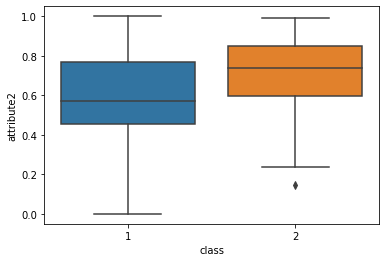

In [90]:
 sns.boxplot( x = 'class',y = 'attribute2', data = df )

In [139]:
df_data=make_drifted_data(stream, 1,-0.3)

In [140]:
df_data

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,class
16343,0.052,0.472,0.008,0.137,0.222,0.191,0.338,0.399,1
16344,0.144,0.566,0.006,0.012,0.168,0.130,0.397,0.504,2
16345,0.166,0.572,0.006,0.137,0.158,0.210,0.448,0.515,2
16346,0.162,0.556,0.007,0.226,0.208,0.210,0.440,0.523,1
16347,0.076,0.477,0.008,0.210,0.201,0.170,0.347,0.429,1
...,...,...,...,...,...,...,...,...,...
18154,0.125,0.461,0.009,0.278,0.441,0.512,0.423,0.446,2
18155,0.165,0.495,0.008,0.278,0.355,0.363,0.561,0.412,1
18156,0.214,0.538,0.007,0.278,0.165,0.170,0.606,0.480,1
18157,0.219,0.536,0.007,0.278,0.115,0.149,0.515,0.515,1


In [141]:
del df_data['class']

In [142]:
batches_d,batch_size=make_batches(df_data)

In [153]:
all_excede_list_d,exceed_count_L2_instThresh_d ,exceed_count_L2_countThresh_d,avg_mse_l2_list_d,mse_list_layer1_d,exceed_count_list_layer1_d=detect_stream_drift(batches_d,encoder_pos_class,encoder_neg_class,thres_zscore_batch_pos,thres_zscore_batch_neg, count_thresh_pos,count_thresh_neg)




**************

Batch Number : 0

Data Points Exceeding Layer 1 Encoder Instance Threshold : [8, 9, 12, 13, 14, 15, 16, 20, 21, 22, 25, 26, 29, 30] 

Data Points Exceeding Layer 2 Encoder Instance Threshold: [0, 1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 31]

Number of Data Points Exceeding Layer 2 Encoder Instance thresholds: 25



**************

Batch Number : 1

Data Points Exceeding Layer 1 Encoder Instance Threshold : [0, 1, 2, 5, 6, 7, 8, 10, 11, 14, 18, 19, 20, 21, 24, 25, 26, 27] 

Data Points Exceeding Layer 2 Encoder Instance Threshold: [0, 1, 2, 3, 5, 10, 11, 14, 15, 16, 21, 22, 23, 24, 25, 26, 29, 30, 31]

Number of Data Points Exceeding Layer 2 Encoder Instance thresholds: 19



**************

Batch Number : 2

Data Points Exceeding Layer 1 Encoder Instance Threshold : [0, 1, 6, 16, 17, 18, 20, 29] 

Data Points Exceeding Layer 2 Encoder Instance Threshold: [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 20, 22, 23, 24, 25, 26, 2

<AxesSubplot:xlabel='class', ylabel='attribute1'>

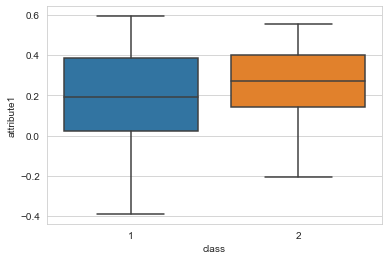

In [279]:
 sns.boxplot( x = 'class',y = 'attribute1', data = df_data )

<AxesSubplot:xlabel='class', ylabel='attribute1'>

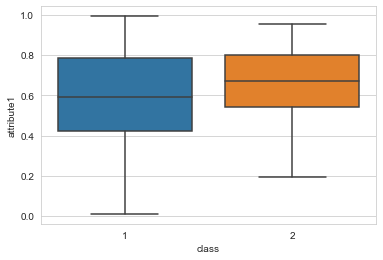

In [280]:
 sns.boxplot( x = 'class',y = 'attribute1', data = stream )

# ESWA Plots 

In [152]:
def plot_batch_mse2(batch_mse):
    df=pd.DataFrame(batch_mse,columns=['MSE'])
    fig, ax = plt.subplots(figsize=(12,5))
    ax.set_title('Batch Reconstruction Error Plot ')
    plt.xlabel("Batch Stream with no Drift")
    plt.ylabel(" Batch Average Reconstruction Error")
    plt.plot(df['MSE'],label="Batch Recons.Error")
    plt.savefig('Batch_Error_plot.png')
    
    f, axes = plt.subplots(figsize=(6,4))
    axes.set_title('Distribution Plot for Batch Reconstruction Error')
    plt.xlabel('Batch Average Reconstruction Error')
    sns.distplot(x=df['MSE'])
    plt.savefig('batch_dist_plot.png')
    
    axes.legend()
    plt.show()  

In [ ]:
all_excede_list_n,exceed_count_L2_instThresh_n ,exceed_count_L2_countThresh_n,avg_mse_l2_list_n,mse_list_layer1_n,exceed_count_list_layer1_n=

No handles with labels found to put in legend.


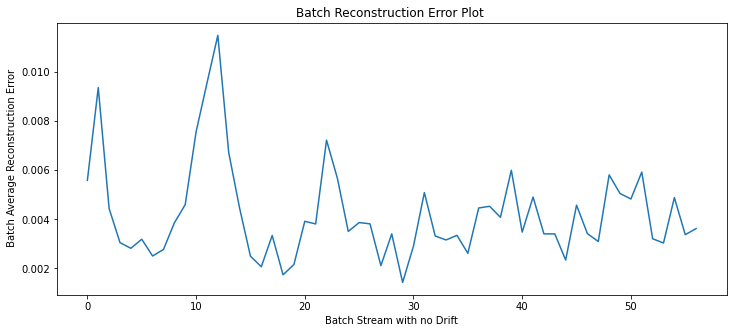

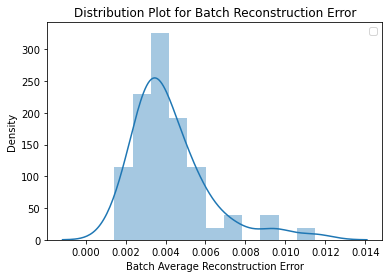

In [179]:
plot_batch_mse2(mse_list_layer1_n)

No handles with labels found to put in legend.


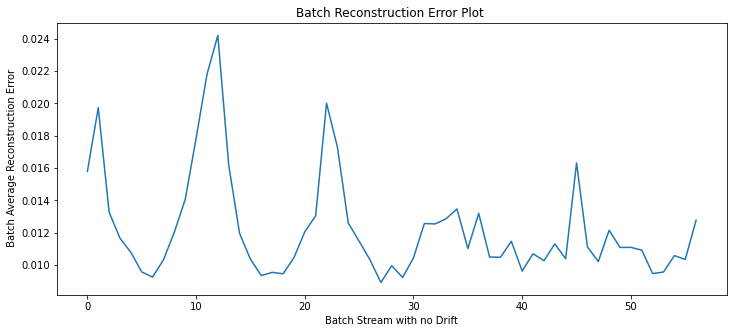

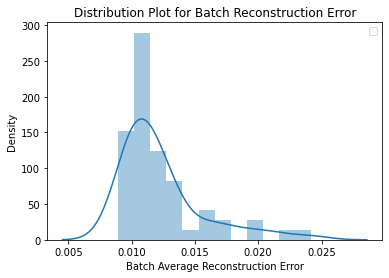

In [180]:
plot_batch_mse2(mse_list_layer1_d)

In [162]:
mse_list_layer1_d;

In [170]:
list(avg_mse_l2_list_d.values());

No handles with labels found to put in legend.


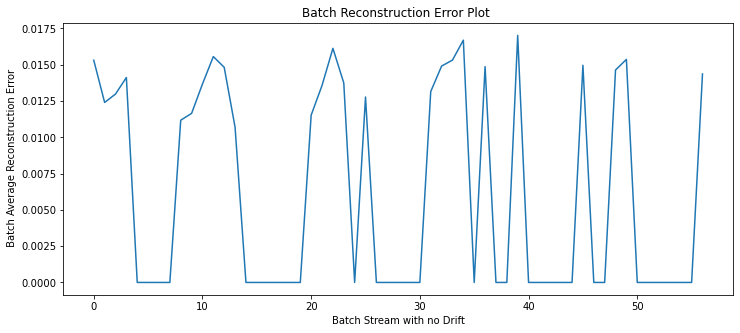

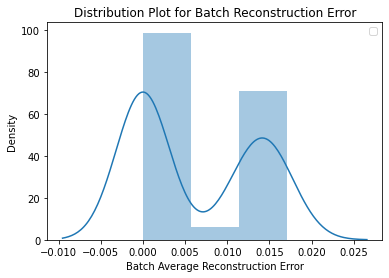

In [181]:
plot_batch_mse2(list(avg_mse_l2_list_d.values()))

No handles with labels found to put in legend.


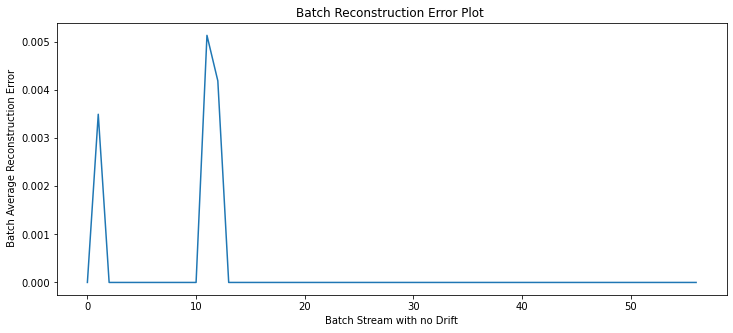

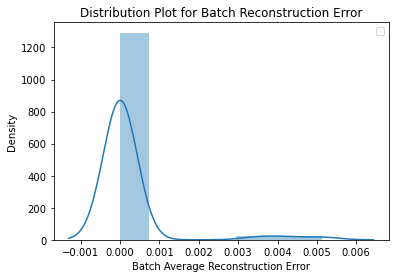

In [182]:
plot_batch_mse2(list(avg_mse_l2_list_n.values()))

In [169]:
import math
def plot_exceed_counts(batch_mse):
    df=pd.DataFrame(batch_mse,columns=['MSE'])
         
    
    fig, ax = plt.subplots(figsize=(12,5))
    ax.set_title('Exceed Counts ')
    plt.xlabel("Batch Stream with Sudden Drift")
    plt.ylabel(" Count Threshold Exceed Count")
    plt.plot(df['MSE'],label="Exceed Counts")
    plt.savefig('exceed_count.png')
    
    f, axes = plt.subplots(figsize=(6,4))
    axes.set_title('Distribution Plot for Exceed Counts')
    plt.xlabel('Exceed Count')
    sns.distplot(x=df['MSE'])
    plt.savefig('exceed_count_thres.png')
    
    axes.legend()
    plt.show()  

In [ ]:
all_excede_list_n,exceed_count_L2_instThresh_n ,exceed_count_L2_countThresh_n,avg_mse_l2_list_n,mse_list_layer1_n,exceed_count_list_layer1_n=

No handles with labels found to put in legend.


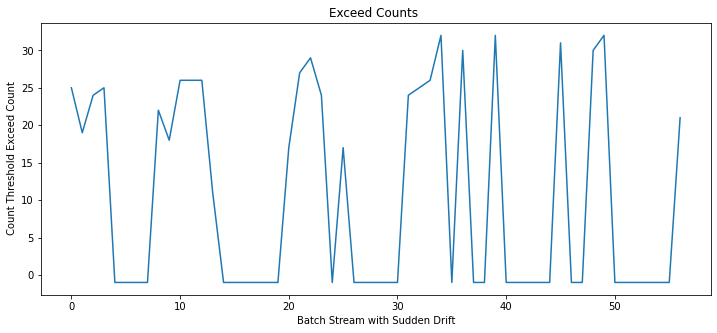

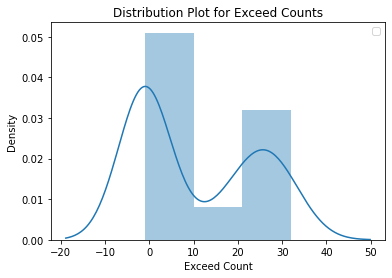

In [186]:
plot_exceed_counts(list(exceed_count_L2_countThresh_d.values()))


No handles with labels found to put in legend.


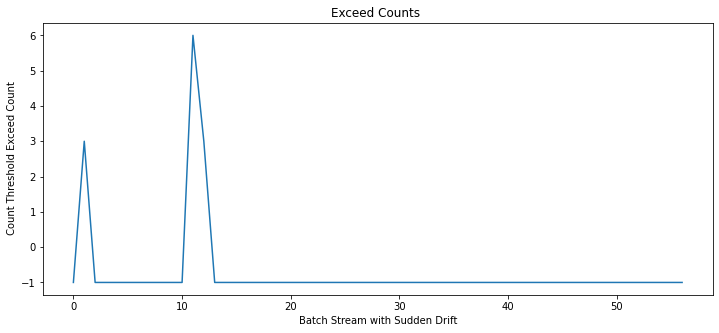

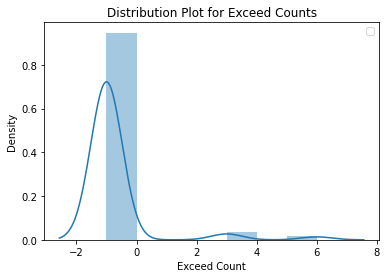

In [185]:
plot_exceed_counts(list(exceed_count_L2_countThresh_n.values()))

No handles with labels found to put in legend.


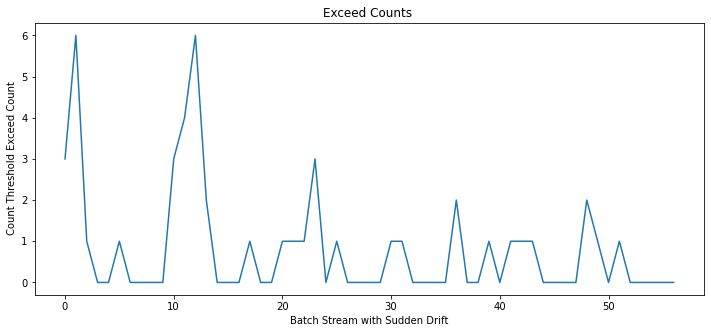

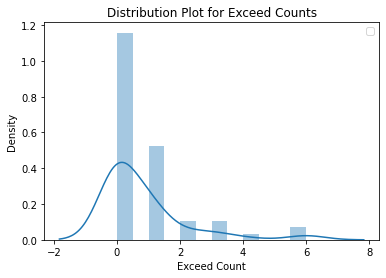

In [183]:
plot_exceed_counts(exceed_count_list_layer1_n)

No handles with labels found to put in legend.


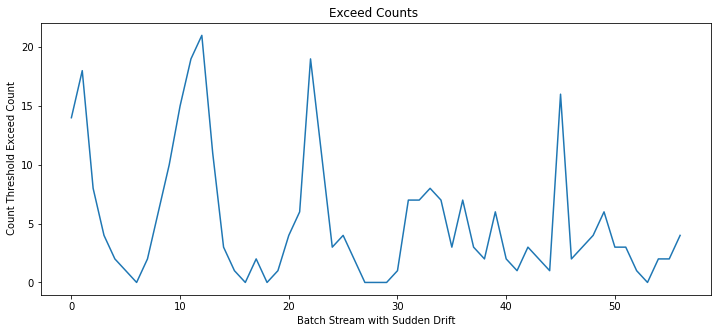

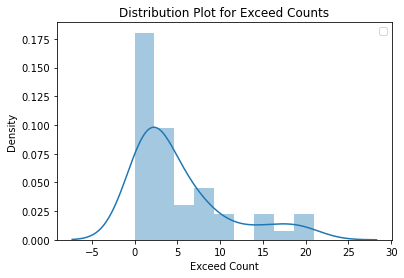

In [184]:
plot_exceed_counts(exceed_count_list_layer1_d)